# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
!pip install cmake
!pip install xgboost

    100% |████████████████████████████████| 17.7MB 1.1MB/s eta 0:00:01   18% |██████                          | 3.3MB 14.1MB/s eta 0:00:02    21% |███████                         | 3.9MB 9.9MB/s eta 0:00:02    25% |████████▏                       | 4.5MB 24.2MB/s eta 0:00:01    36% |███████████▋                    | 6.4MB 12.9MB/s eta 0:00:01    47% |███████████████                 | 8.3MB 9.4MB/s eta 0:00:01    54% |█████████████████▍              | 9.6MB 28.1MB/s eta 0:00:01    57% |██████████████████▍             | 10.2MB 26.5MB/s eta 0:00:01    64% |████████████████████▋           | 11.4MB 12.6MB/s eta 0:00:01    67% |█████████████████████▊          | 12.0MB 12.6MB/s eta 0:00:01    70% |██████████████████████▋         | 12.5MB 9.2MB/s eta 0:00:01    73% |███████████████████████▋        | 13.1MB 24.3MB/s eta 0:00:01    80% |█████████████████████████▉      | 14.3MB 13.0MB/s eta 0:00:01    84% |███████████████████████████     | 14.9MB 26.1MB/s eta 0:00:01    94% |█████████████████████

In [59]:
# import libraries here; add more as necessary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 0.1. Loading data and exploration of the dataframes

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
value_att = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', )
del value_att['Unnamed: 0']

In [4]:
# some information about azdias dataframe

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
azdias.shape

(891221, 366)

In [7]:
azdias.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 366 columns):
LNR                            891221 non-null int64
AGER_TYP                       891221 non-null int64
AKT_DAT_KL                     817722 non-null float64
ALTER_HH                       817722 non-null float64
ALTER_KIND1                    81058 non-null float64
ALTER_KIND2                    29499 non-null float64
ALTER_KIND3                    6170 non-null float64
ALTER_KIND4                    1205 non-null float64
ALTERSKATEGORIE_FEIN           628274 non-null float64
ANZ_HAUSHALTE_AKTIV            798073 non-null float64
ANZ_HH_TITEL                   794213 non-null float64
ANZ_KINDER                     817722 non-null float64
ANZ_PERSONEN                   817722 non-null float64
ANZ_STATISTISCHE_HAUSHALTE     798073 non-null float64
ANZ_TITEL                      817722 non-null float64
ARBEIT                         794005 non-null float64
BALLRAUM          

In [8]:
# some information about customer dataframe

In [9]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [10]:
customers.shape

(191652, 369)

In [11]:
customers.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 369 columns):
LNR                            191652 non-null int64
AGER_TYP                       191652 non-null int64
AKT_DAT_KL                     145056 non-null float64
ALTER_HH                       145056 non-null float64
ALTER_KIND1                    11766 non-null float64
ALTER_KIND2                    5100 non-null float64
ALTER_KIND3                    1275 non-null float64
ALTER_KIND4                    236 non-null float64
ALTERSKATEGORIE_FEIN           139810 non-null float64
ANZ_HAUSHALTE_AKTIV            141725 non-null float64
ANZ_HH_TITEL                   139542 non-null float64
ANZ_KINDER                     145056 non-null float64
ANZ_PERSONEN                   145056 non-null float64
ANZ_STATISTISCHE_HAUSHALTE     141725 non-null float64
ANZ_TITEL                      145056 non-null float64
ARBEIT                         141176 non-null float64
BALLRAUM            

In [6]:
# some information about value_att dataframe

In [7]:
value_att.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In value_att dataframe, we can find description and meaning of each attribute. We can use them in further steps.

### 0.2.The difference between columns of azdias and customers dataframes

In [12]:
# columns in customers not in azdias
diff_cust_azdias=np.setdiff1d(customers.columns, azdias.columns)

In [13]:
diff_cust_azdias

array(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype=object)

In [14]:
# columns in azdias not in customers
np.setdiff1d(azdias.columns, customers.columns)

array([], dtype=object)

### 0.3. Exploration of null values in azdias dataframe

In [15]:
azdias_nan_mean=azdias.isnull().mean()

In [16]:
azdias_nan_mean.sort_values(ascending=False)

ALTER_KIND4                    0.998648
ALTER_KIND3                    0.993077
ALTER_KIND2                    0.966900
ALTER_KIND1                    0.909048
EXTSEL992                      0.733996
KK_KUNDENTYP                   0.655967
ALTERSKATEGORIE_FEIN           0.295041
D19_LETZTER_KAUF_BRANCHE       0.288495
D19_LOTTO                      0.288495
D19_VERSI_ONLINE_QUOTE_12      0.288495
D19_BANKEN_ONLINE_QUOTE_12     0.288495
D19_SOZIALES                   0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_KONSUMTYP                  0.288495
D19_TELKO_ONLINE_QUOTE_12      0.288495
D19_VERSAND_ONLINE_QUOTE_12    0.288495
KBA05_MOTOR                    0.149597
KBA05_MOD8                     0.149597
KBA05_MOD4                     0.149597
KBA05_MOD3                     0.149597
KBA05_MOD2                     0.149597
KBA05_SEG1                     0.149597
KBA05_MOD1                     0.149597
KBA05_MAXVORB                  0.149597
KBA05_MAXSEG                   0.149597


Text(0,0.5,'Proportion of missing value in column')

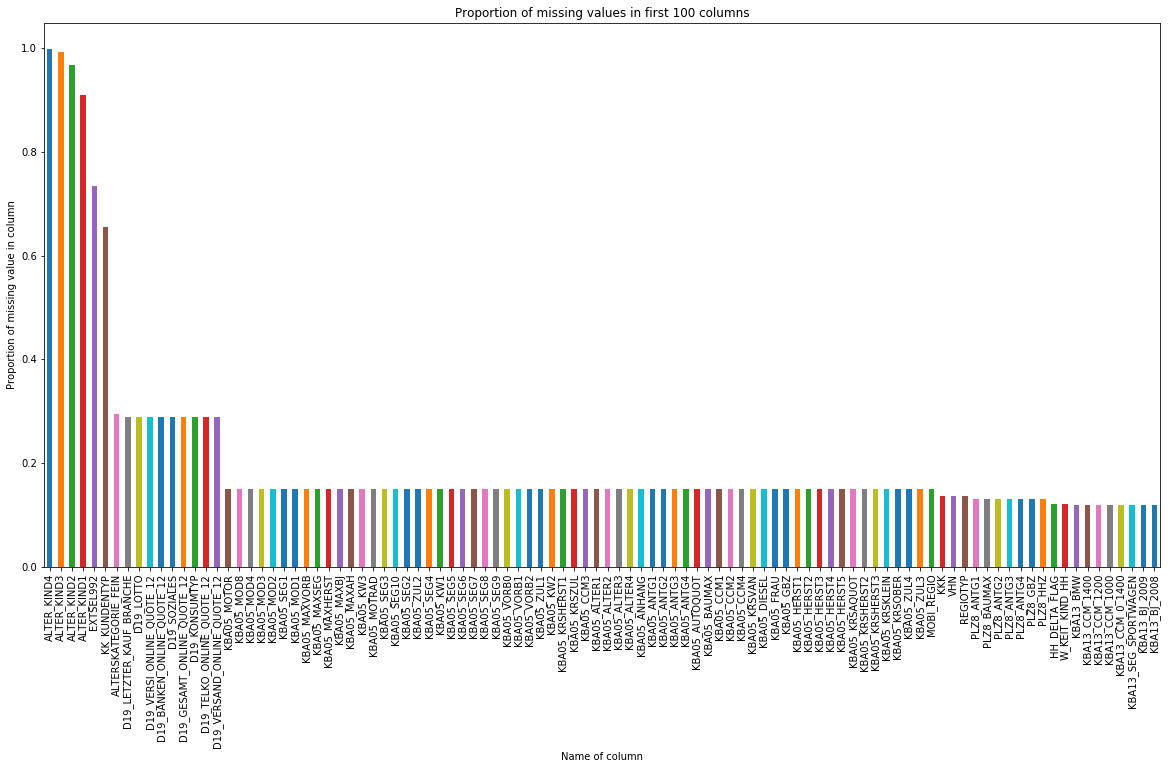

In [17]:
azdias_nan_mean.sort_values(ascending=False)[:100].plot(kind="bar", figsize=[20,10])

plt.title("Proportion of missing values in first 100 columns")
plt.xlabel("Name of column")
plt.ylabel("Proportion of missing value in column")

ALTER_KIND4, ALTER_KIND3, ALTER_KIND2, ALTER_KIND1, KK_KUNDENTYP, EXTSEL992 are the columns which includes highest amounts of NaN values. They have more than 60% missing values.

Text(0,0.5,'Number of columns')

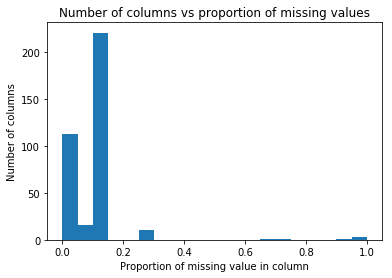

In [18]:
plt.hist(azdias_nan_mean, bins=20)

plt.title("Number of columns vs proportion of missing values")
plt.xlabel("Proportion of missing value in column")
plt.ylabel("Number of columns")

In the histogram, we can see that missing values in most of the columns less than 20%. There are few columns whose proportion of missing values more than 60%.

When we look at the rows:

In [19]:
azdias_row_nan_mean=azdias.isnull().mean(axis=1)

In [20]:
azdias_row_nan_mean.sort_values(ascending=False)

55664     0.707650
537799    0.707650
350182    0.707650
373501    0.707650
826869    0.707650
739769    0.704918
475330    0.704918
5099      0.704918
140317    0.704918
522174    0.704918
629707    0.704918
716386    0.704918
57866     0.704918
23667     0.704918
332962    0.704918
347712    0.704918
255742    0.704918
228624    0.699454
376576    0.691257
376536    0.691257
376578    0.691257
376534    0.691257
766507    0.691257
376523    0.691257
851362    0.691257
851358    0.691257
376506    0.691257
376499    0.691257
376490    0.691257
376586    0.691257
            ...   
145368    0.000000
711806    0.000000
85307     0.000000
89844     0.000000
19457     0.000000
677298    0.000000
594450    0.000000
730082    0.000000
48547     0.000000
33736     0.000000
555614    0.000000
837125    0.000000
54129     0.000000
436519    0.000000
415359    0.000000
856386    0.000000
377279    0.000000
193782    0.000000
664563    0.000000
617078    0.000000
642237    0.000000
346347    0.

Text(0,0.5,'Number of rows')

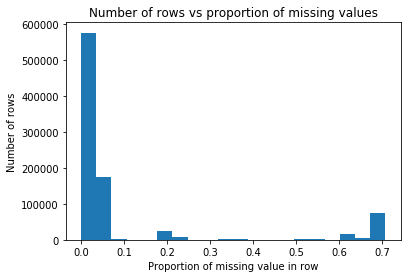

In [21]:
plt.hist(azdias_row_nan_mean, bins=20)

plt.title("Number of rows vs proportion of missing values")
plt.xlabel("Proportion of missing value in row")
plt.ylabel("Number of rows")

According to the histogram, around 800,000 rows have missing values less than 10% of them. There are around 100,000 rows whose missing value percent is more than 60%.

#### Removing missing values

In [22]:
# We need to find out which columns and rows to drop

In [23]:
# columns

In [24]:
azdias_nan_mean[azdias_nan_mean>0.3]

ALTER_KIND1     0.909048
ALTER_KIND2     0.966900
ALTER_KIND3     0.993077
ALTER_KIND4     0.998648
EXTSEL992       0.733996
KK_KUNDENTYP    0.655967
dtype: float64

In [25]:
columns_to_drop=azdias_nan_mean[azdias_nan_mean>0.3].index

In [26]:
columns_to_drop

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')

In [27]:
# getting copy azdias
azdias_clean=azdias.copy()

In [28]:
# dropping columns to drop
azdias_clean.drop(columns=columns_to_drop, inplace=True)

In [29]:
# rows

In [30]:
azdias_row_nan_mean[azdias_row_nan_mean>0.5]

0         0.688525
11        0.691257
14        0.691257
17        0.691257
24        0.691257
26        0.543716
30        0.644809
35        0.688525
46        0.644809
48        0.691257
53        0.688525
54        0.691257
61        0.688525
62        0.688525
69        0.691257
75        0.691257
76        0.688525
81        0.688525
83        0.688525
90        0.644809
97        0.691257
99        0.691257
103       0.691257
106       0.688525
108       0.691257
109       0.688525
112       0.691257
133       0.691257
137       0.691257
138       0.603825
            ...   
891021    0.688525
891027    0.688525
891044    0.691257
891049    0.691257
891055    0.620219
891061    0.688525
891062    0.546448
891063    0.688525
891064    0.691257
891069    0.554645
891072    0.691257
891074    0.644809
891092    0.691257
891095    0.691257
891100    0.614754
891117    0.546448
891119    0.568306
891120    0.535519
891130    0.612022
891137    0.617486
891140    0.617486
891159    0.

In [31]:
len(azdias_row_nan_mean[azdias_row_nan_mean>0.5])

99231

In [32]:
rows_to_drop=azdias_row_nan_mean[azdias_row_nan_mean>0.5].index

In [33]:
rows_to_drop

Int64Index([     0,     11,     14,     17,     24,     26,     30,     35,
                46,     48,
            ...
            891140, 891159, 891164, 891170, 891171, 891172, 891173, 891175,
            891185, 891187],
           dtype='int64', length=99231)

In [34]:
# dropping rows
azdias_clean.drop(rows_to_drop, inplace=True)

In [35]:
print("shape before cleaning: ", azdias.shape)
print("shape after cleaning: ", azdias_clean.shape)

shape before cleaning:  (891221, 366)
shape after cleaning:  (791990, 360)


### 0.4. Removing the columns which involve too many features

In [36]:
# checking feature counts and types of the columns
too_many_feat=[]
for col in azdias_clean.columns:
    if azdias_clean[col].nunique()>25:
        too_many_feat.append((col, azdias_clean[col].nunique(), azdias_clean[col].dtypes))

In [37]:
too_many_feat

[('LNR', 791990, dtype('int64')),
 ('ALTERSKATEGORIE_FEIN', 26, dtype('float64')),
 ('ANZ_HAUSHALTE_AKTIV', 292, dtype('float64')),
 ('ANZ_PERSONEN', 29, dtype('float64')),
 ('ANZ_STATISTISCHE_HAUSHALTE', 268, dtype('float64')),
 ('CAMEO_DEU_2015', 45, dtype('O')),
 ('CAMEO_INTL_2015', 43, dtype('O')),
 ('D19_LETZTER_KAUF_BRANCHE', 35, dtype('O')),
 ('EINGEFUEGT_AM', 4474, dtype('O')),
 ('EINGEZOGENAM_HH_JAHR', 37, dtype('float64')),
 ('GEBURTSJAHR', 117, dtype('int64')),
 ('KBA13_ANZAHL_PKW', 1261, dtype('float64')),
 ('LP_LEBENSPHASE_FEIN', 41, dtype('float64')),
 ('MIN_GEBAEUDEJAHR', 29, dtype('float64')),
 ('VERDICHTUNGSRAUM', 46, dtype('float64'))]

Some of these columns look problematic.
1. LNR column has so many unique value bu it is ID column. So, we will keep it.
2. CAMEO_DEU_2015, CAMEO_INTL_2015, D19_LETZTER_KAUF_BRANCHE and are categorical columns which have too many features.
3. EINGEFUEGT_AM column seems to a categorical column and it should be in datetime type.

In [38]:
# change dtype of EINGEFUEGT_AM column from object to datetime
azdias_clean["EINGEFUEGT_AM"]=pd.to_datetime(azdias_clean["EINGEFUEGT_AM"])

In [39]:
# extract only year
azdias_clean["EINGEFUEGT_AM"]=pd.DatetimeIndex(azdias_clean["EINGEFUEGT_AM"]).year

In [40]:
azdias_clean["EINGEFUEGT_AM"].head()

1    1992
2    1992
3    1997
4    1992
5    1992
Name: EINGEFUEGT_AM, dtype: int64

In [41]:
# dropping columns that have too many features and id column
azdias_clean.drop(columns=["CAMEO_DEU_2015", "CAMEO_INTL_2015", "D19_LETZTER_KAUF_BRANCHE"], inplace=True)

In [42]:
azdias_clean.shape

(791990, 356)

### 0.5.Converting categorical columns to encoded and dummies

In [43]:
# Finding categorical columns

In [44]:
categorical_cols=[]
for col in azdias_clean.columns:
    if azdias_clean[col].dtypes=="object":
        categorical_cols.append((col, azdias_clean[col].nunique()))
categorical_cols

[('CAMEO_DEUG_2015', 19), ('OST_WEST_KZ', 2)]

In [45]:
# CAMEO_DEUG_2015 column has too many features so converting encoded instead dummies seems better
azdias_clean["CAMEO_DEUG_2015"]=pd.factorize(azdias_clean["CAMEO_DEUG_2015"])[0]

In [46]:
# getting dummy column for OST_WEST_KZ
azdias_clean=pd.get_dummies(azdias_clean, drop_first=True)

In [47]:
azdias_clean.shape

(791990, 356)

### 0.6. Completing missing values

In [48]:
print("number of missing values in azdias before imputing: ", azdias_clean.isnull().sum().sum())

number of missing values in azdias before imputing:  4952737


In [49]:
# impute Nan values by using sklern impute function by using mode strategy

imputer = SimpleImputer(strategy='most_frequent')

In [50]:
# fit and transform of imputer on dataframe

azdias_clean=pd.DataFrame(imputer.fit_transform(azdias_clean), columns = azdias_clean.columns)

In [51]:
print("number of missing values in azdias after imputing: ", azdias_clean.isnull().sum().sum())

number of missing values in azdias after imputing:  0


### 0.7. Identify and remove correlated features

In [52]:
# getting absolute value correlation matrix by using corr from pandas
corr_fet = azdias_clean.corr().abs()

In [53]:
corr_fet.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
AGER_TYP,1.000000,0.281603,0.002101,0.405207,0.025516,0.001925,0.132502,0.014562,0.020573,0.011471,...,0.051294,0.189732,0.289147,0.239132,0.143615,0.012730,0.154369,0.014680,0.340526,0.021134
AKT_DAT_KL,0.281603,1.000000,0.177541,0.298895,0.119516,0.028476,0.077344,0.142287,0.120605,0.008584,...,0.374296,0.410785,0.384257,0.000127,0.043381,0.036304,0.179195,0.040862,0.196882,0.009064
ALTER_HH,0.002101,0.177541,1.000000,0.301095,0.076373,0.042730,0.180002,0.331046,0.082307,0.014119,...,0.395162,0.316018,0.196415,0.275779,0.050558,0.026028,0.089730,0.016196,0.158987,0.020931
ALTERSKATEGORIE_FEIN,0.405207,0.298895,0.301095,1.000000,0.016916,0.022308,0.182173,0.042611,0.008105,0.025262,...,0.139947,0.020063,0.157347,0.316126,0.220822,0.008741,0.161351,0.018834,0.437378,0.001677
ANZ_HAUSHALTE_AKTIV,0.025516,0.119516,0.076373,0.016916,1.000000,0.376456,0.059125,0.121949,0.976960,0.003048,...,0.150016,0.144348,0.124830,0.092482,0.055940,0.083930,0.174313,0.004459,0.018918,0.093038


In [54]:
# upper triangle of correlation matrix
upper = corr_fet.where(np.triu(np.ones(corr_fet.shape), k=1).astype(np.bool))
upper.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
AGER_TYP,NaN,0.281603,0.002101,0.405207,0.025516,0.001925,0.132502,0.014562,0.020573,0.011471,...,0.051294,0.189732,0.289147,0.239132,0.143615,0.012730,0.154369,0.014680,0.340526,0.021134
AKT_DAT_KL,NaN,NaN,0.177541,0.298895,0.119516,0.028476,0.077344,0.142287,0.120605,0.008584,...,0.374296,0.410785,0.384257,0.000127,0.043381,0.036304,0.179195,0.040862,0.196882,0.009064
ALTER_HH,NaN,NaN,NaN,0.301095,0.076373,0.042730,0.180002,0.331046,0.082307,0.014119,...,0.395162,0.316018,0.196415,0.275779,0.050558,0.026028,0.089730,0.016196,0.158987,0.020931
ALTERSKATEGORIE_FEIN,NaN,NaN,NaN,NaN,0.016916,0.022308,0.182173,0.042611,0.008105,0.025262,...,0.139947,0.020063,0.157347,0.316126,0.220822,0.008741,0.161351,0.018834,0.437378,0.001677
ANZ_HAUSHALTE_AKTIV,NaN,NaN,NaN,NaN,NaN,0.376456,0.059125,0.121949,0.976960,0.003048,...,0.150016,0.144348,0.124830,0.092482,0.055940,0.083930,0.174313,0.004459,0.018918,0.093038


In [55]:
threshold=0.85

In [56]:
# Selecting columns whose correlation above the threshold
cols_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

cols_to_drop

['ANZ_STATISTISCHE_HAUSHALTE',
 'CJT_TYP_2',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP_MAX',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'KBA05_KRSAQUOT',
 'KBA05_KRSHERST1',
 'KBA05_KRSHERST2',
 'KBA05_KRSHERST3',
 'KBA05_SEG2',
 'KBA05_SEG5',
 'KBA05_SEG6',
 'KBA05_SEG9',
 'KBA05_ZUL4',
 'KBA13_HALTER_40',
 'KBA13_HALTER_55',
 'KBA13_HALTER_66',
 'KBA13_HERST_SONST',
 'KBA13_KMH_250',
 'KBA13_SITZE_5',
 'KBA13_VW',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_GROB',
 'MIN_GEBAEUDEJAHR',
 'ORTSGR_KLS9',
 'PLZ8_ANTG1',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',
 'PLZ8_GBZ',
 'PLZ8_HHZ',
 'VK_DISTANZ',
 'VK_ZG11',
 'ANREDE_KZ']

In [57]:
len(cols_to_drop)

45

In [58]:
# dropping most correlated columns (>0.85)
azdias_clean.drop(columns=cols_to_drop, inplace=True)

In [59]:
azdias_clean.shape

(791990, 311)

### 0.8. Removing outliers from dataset

In [60]:
# calculate z score for each value in dataset
z = np.abs(stats.zscore(azdias_clean))

In [61]:
# filter all rows whose z score less than 6
azdias_clean = azdias_clean[(z < 6).all(axis=1)]

In [62]:
azdias_clean.shape

(688713, 311)

### 0.9. Standardization of dataset

In [63]:
# define scaler by using StandardScaler from sklearn, which standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

In [64]:
# fit and transform of scaler on dataframe
azdias_clean=pd.DataFrame(scaler.fit_transform(azdias_clean), columns = azdias_clean.columns)

In [65]:
azdias_clean.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
0,-0.572573,1.222088,0.835070,0.684332,0.242362,-0.147496,-0.295067,-0.611189,0.0,-0.178999,...,-0.557781,-0.375764,-0.357962,0.996437,-0.626223,0.551127,-1.067185,1.130249,0.162732,0.50669
1,1.851919,-0.959254,0.309388,-0.202169,-0.628346,-0.147496,-0.295067,-1.523856,0.0,-1.183259,...,-0.557781,0.517486,-2.098319,0.284947,0.967550,0.551127,1.554442,-0.294103,1.088797,0.50669
2,2.660083,-0.959254,-0.084874,-0.867045,-0.241365,-0.147496,-0.295067,-0.611189,0.0,-1.183259,...,0.825610,-0.375764,-0.357962,1.352182,0.967550,0.551127,1.554442,0.418073,-1.689396,0.50669
3,-0.572573,1.222088,-1.399080,0.241081,-0.338110,-0.147496,-0.295067,-0.611189,0.0,0.825261,...,-0.557781,-0.375764,-0.357962,0.284947,-0.626223,0.551127,0.505791,0.418073,-0.763332,0.50669
4,-0.572573,-0.959254,0.440808,0.019456,-0.144619,-0.147496,-0.295067,-0.611189,0.0,-1.183259,...,-0.557781,-0.375764,-0.357962,1.352182,0.436293,0.551127,-1.591510,-1.718455,-1.689396,0.50669


### 0.10. Creating preprocessing function

We cleaned azdias dataframe by dropping columns and rows whose most of them missing, removing id columns, converting categorical columns to numerical and completing the missing columns. We need to follow same steps for the customer dataset for second step: clustering. 

In [8]:
def data_preprocessing (df, df_name = None):
    """
    Perform cleaning of demographics dataset by dropping missing columns and rows, reencoding, 
    completing missing values, and dropping correlated features
    
    Input: 
    df: Demographic dataset (DataFrame)
    df_name: Name of dataframe (str)
    
    Output:
    df_clean: Cleaned dataset (DataFrame)
    """
    # Get copy of df
    df_clean=df.copy()
    
    # Drop columns from customer dataset, which are not found in azdias dataset 
    if df_name=='customers':
        df_clean.drop(columns= ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    # Drop columns which involve too many missing values
    df_clean.drop(columns= ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP'], 
                  inplace=True)
    
    # Find the rows that include too many missing values and drop them if ratio of missing values more than 0.5
    df_row_nan_mean=df_clean.isnull().mean(axis=1)
    rows_to_drop=df_row_nan_mean[df_row_nan_mean>0.5].index
    df_clean.drop(rows_to_drop, inplace=True)
    
    # Remove the columns which involve too many features
    df_clean.drop(columns=["LNR", "CAMEO_DEU_2015", "CAMEO_INTL_2015", "D19_LETZTER_KAUF_BRANCHE"], inplace=True)
    
    # Change dtype of EINGEFUEGT_AM column from object to datetime and extract only year
    df_clean["EINGEFUEGT_AM"]=pd.to_datetime(df_clean["EINGEFUEGT_AM"])
    df_clean["EINGEFUEGT_AM"]=pd.DatetimeIndex(df_clean["EINGEFUEGT_AM"]).year
    
    # Convert categorical column to encoded
    df_clean["CAMEO_DEUG_2015"]=pd.factorize(df_clean["CAMEO_DEUG_2015"])[0]
    
    # Convert categorical column to encoded
    df_clean=pd.get_dummies(df_clean, drop_first=True)
        
    # Impute missing values with mode value
    imputer = SimpleImputer(strategy='most_frequent')
    df_clean=pd.DataFrame(imputer.fit_transform(df_clean), columns = df_clean.columns)
    
    # Identify and remove 45 correlated features
    
    df_clean.drop(columns=['ANZ_STATISTISCHE_HAUSHALTE', 'CJT_TYP_2', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
    'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12',
    'D19_KONSUMTYP_MAX', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM',
    'D19_VERSAND_ONLINE_QUOTE_12', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3',
    'KBA05_SEG2', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG9', 'KBA05_ZUL4', 'KBA13_HALTER_40', 'KBA13_HALTER_55',
    'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'KBA13_KMH_250', 'KBA13_SITZE_5', 'KBA13_VW', 'LP_FAMILIE_GROB',
    'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB', 'MIN_GEBAEUDEJAHR', 'ORTSGR_KLS9', 'PLZ8_ANTG1',
    'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'VK_DISTANZ', 'VK_ZG11', 'ANREDE_KZ'], inplace=True)
    
    # Remove outliers from dataset by using z score
    z = np.abs(stats.zscore(df_clean))
    df_clean = df_clean[(z < 6).all(axis=1)]
    
    # Standardization of dataset
    lnr=df_clean['LNR'] # to keep LNR column same
    scaler = StandardScaler()
    df_clean=pd.DataFrame(scaler.fit_transform(df_clean), columns = df_clean.columns)
    df_clean['LNR']=lnr
    
    # set index LNR column
    df_clean.set_index("LNR", inplace=True)

    return df_clean

Lets apply the function to customer dataset

In [6]:
customer_clean = data_preprocessing (customers, df_name = "customers")

In [7]:
customer_clean.shape

(121955, 311)

In [ ]:
np.setdiff1d(customer_clean.columns, azdias_clean.columns)

customer_clean and azdias clean dataframes have same columns.

In [8]:
azdias_clean = data_preprocessing (azdias, df_name = "azdias")

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1. Reduction of dimensionality 

Use Principal component analysis from (PCA) from sklearn.

In [9]:
pca = PCA().fit(azdias_clean)

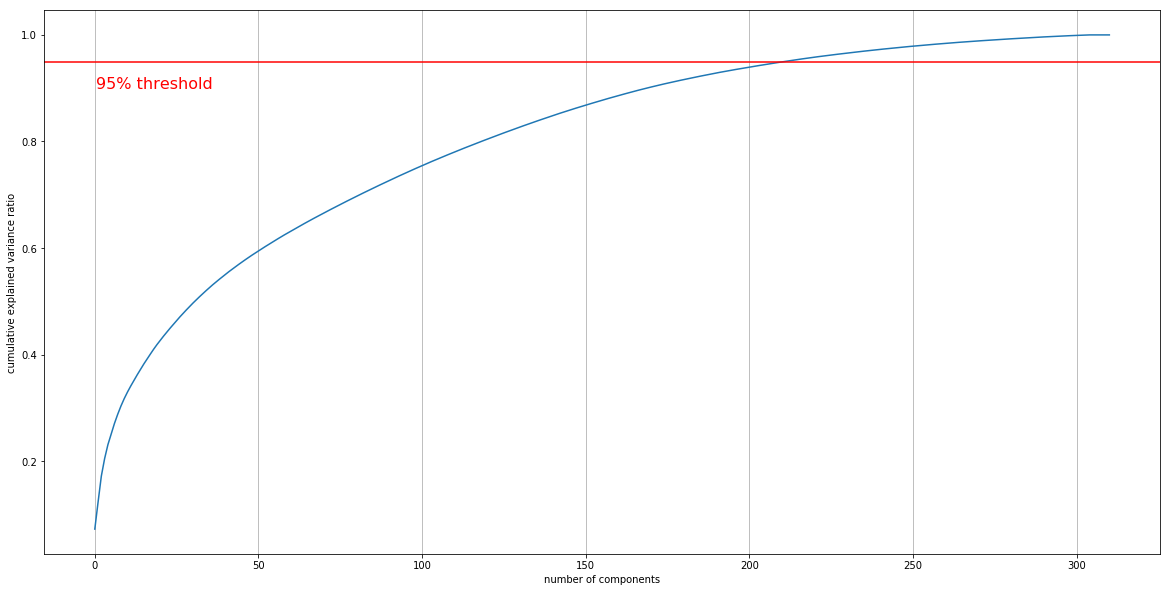

In [10]:
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance ratio')

plt.axhline(y=0.95, color='r')
plt.text(0.5, 0.9, '95% threshold', color = 'red', fontsize=16)

plt.grid(axis='x')


According the graph above, number of component for 95% threshold is around 215.

#### 1.1.1. Dimension reduction function

In [9]:
def pca_reduction(df, n_components):
    """
    Perform PCA dimension reduction to dataset
    
    Input: 
    df: Demographic dataset (DataFrame)
    n_components: Number of components for PCA
    
    Output:
    df_reduced: PCA applied dataset (DataFrame)
    pca: PCA object
    """
    # PCA
    pca = PCA(n_components=n_components)
    # fit and transform of PCA
    df_reduced = pd.DataFrame(pca.fit_transform(df), columns=["PC"+str(i) for i in range(n_components)])
    
    return df_reduced, pca

In [10]:
azdias_reduced, azdias_pca = pca_reduction(azdias_clean, 215)

In [11]:
azdias_reduced.shape

(688741, 215)

In [12]:
customer_reduced, customer_pca = pca_reduction(customer_clean, 215)

In [13]:
customer_reduced.shape

(121955, 215)

#### 1.1.2. PCA plot function

In [14]:
def pca_plot(pca, threshold=0.95):

    """
    Perform cumulative sum of PCA explained_variance_ratio_ then plot
    cumulative explained variance ratio vs number of components
    
    Input: 
    pca: PCA object
    threshold: threshold for cumulative explained variance ratio (int, default=0.95)
    
    Output:
    return None
    """
    
    plt.figure(figsize=(16,8))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance ratio')

    plt.axhline(y=threshold, color='r')
    plt.text(0.5, threshold-0.05, str(threshold*100)+'% threshold', color = 'red', fontsize=16)

    plt.grid(axis='x')

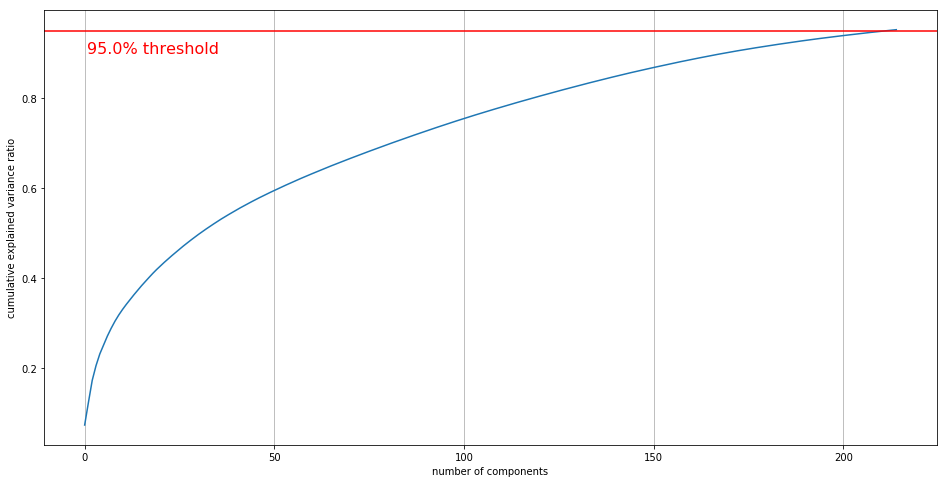

In [15]:
pca_plot(azdias_pca)

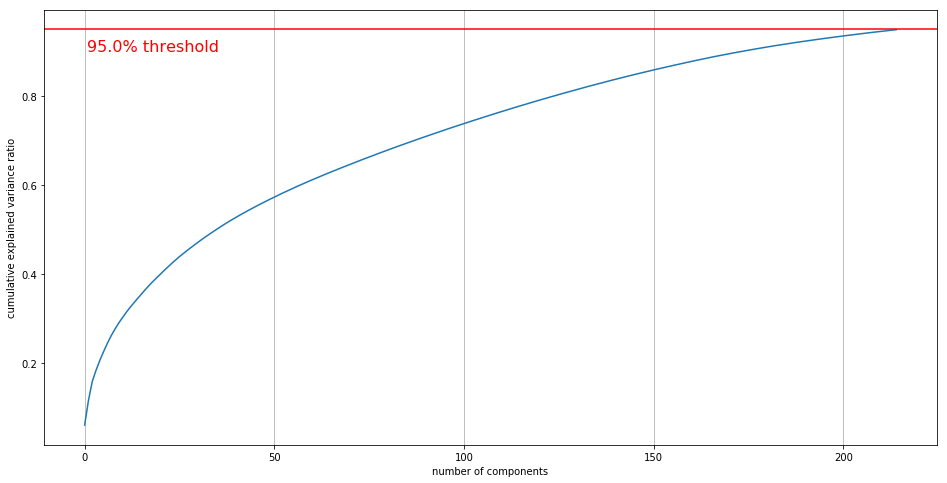

In [16]:
pca_plot(customer_pca)

By using the plots above, we can see that our dimensions are enough for the threshold which 95%.

#### 1.1.3. PCA feature importance

PCA is also important to determine the feature importance. I prepared functions. One of them creates a matrix which shows feature weights for each principal components. 
<br>In the final dataframe, principal components are sorted according to importance. So, PC 0 is the most important one.

In [17]:
def pca_feature_importance(pca, df):

    """
    Create a matrix which involves feature weights for every principal components
    
    Input: 
    pca: PCA object for df
    df: Demographic dataset (DataFrame)
    
    Output:
    fet_import_matrix: feature importance for each principal component matrix (DataFrame)
    
    """
    # number of components
    n_comp= pca.n_components_
    
    # index column of dataframe
    idx=["PC"+str(i) for i in range(n_comp)]
    
    # create dataframe
    fet_import_matrix=pd.DataFrame((pca.components_), columns=df.columns, index=idx)
    
    return fet_import_matrix

In [18]:
azdias_pca_feature_importance = pca_feature_importance(azdias_pca, azdias_clean)

In [19]:
azdias_pca_feature_importance.shape

(215, 311)

In [20]:
azdias_pca_feature_importance.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
PC0,0.042823,-0.072772,0.027583,-0.040640,-0.108187,-0.021802,0.023589,0.072847,-0.000000e+00,-0.108179,...,0.004563,0.048427,-0.037194,-0.080613,-0.033730,0.032988,0.046203,-0.096628,0.051987,0.057270
PC1,-0.027390,0.029917,-0.007878,0.022467,0.031184,0.026655,-0.002052,-0.021882,1.355253e-20,-0.032407,...,-0.001117,-0.030673,0.044826,0.023989,0.005340,-0.021003,-0.084542,0.009952,-0.032816,0.108505
PC2,-0.130382,0.031102,0.101887,0.165785,-0.022632,-0.011388,0.079798,0.062512,6.776264e-21,-0.032339,...,-0.002931,0.003530,-0.023759,-0.098751,-0.118191,-0.064426,0.033618,0.041679,-0.181126,0.013248
PC3,0.069525,-0.118861,0.090880,-0.014189,0.036146,0.017183,0.046273,0.121131,-8.673617e-19,0.091098,...,0.031745,0.092245,0.018726,-0.177369,-0.047469,0.001218,-0.082396,-0.044307,0.036686,-0.066458
PC4,-0.027918,0.035545,-0.014693,0.024659,0.011580,0.009584,-0.008832,-0.034159,-6.938894e-18,0.076806,...,0.001455,-0.016778,-0.033662,0.025275,0.003468,-0.012622,-0.023086,0.019593,-0.038462,-0.163040


Second function creates a dataframe involves top feature weights with feature description for spesific principal component.

In [21]:
def most_important_features(pca_feature_importance_matrix, df, df_attribute, component_number):
    """
    Create a dataframe involves top feature weights with feature description for spesific principal component
    
    Input: 
    pca_feature_importance_matrix: pca_feature_importance_matrix: PCA feature importance for 
                                    each principal component matrix (DataFrame)
    df: Demographic dataset (DataFrame)
    df_attribute: Dataset which includes descriptions and meanings of features
    component_number: number of the component (int)
    
    Output:
    pc_tops: top 3 positive and negative features with description and meaning for principal component given
    
    """
    # select top 3 and bottom 3 features from pca_feature_importance_matrix
    pc_tops=pd.DataFrame(pca_feature_importance_matrix.iloc[component_number].sort_values(ascending=False).iloc[[0,1,2,-3,-2,-1]])
    
    # merge pc_tops with attributes dataset
    pc_tops = pd.merge(left=pc_tops, right=df_attribute, how='left', left_on=pc_tops.index, right_on='Attribute')
    
    # set index attribute column
    pc_tops=pc_tops.set_index("Attribute").drop(columns=["Value"])
    
    return pc_tops

In [22]:
most_important_features(azdias_pca_feature_importance, azdias_clean, value_att, 0)

,PC0,Description,Meaning
Attribute,,,
KBA13_ANTG1,0.152924,NaN,NaN
MOBI_REGIO,0.152100,moving patterns,very high mobility
LP_STATUS_FEIN,0.149898,social status fine,typical low-income earners
KBA13_BAUMAX,-0.145598,NaN,NaN
HH_EINKOMMEN_SCORE,-0.148534,estimated household net income,unknown
KBA13_ANTG3,-0.151954,NaN,NaN


In [23]:
most_important_features(azdias_pca_feature_importance, azdias_clean, value_att, 1)

,PC1,Description,Meaning
Attribute,,,
KBA13_HERST_BMW_BENZ,0.197164,share of BMW & Mercedes Benz within the PLZ8,unknown
KBA13_SEG_OBEREMITTELKLASSE,0.169697,share of upper middle class cars and upper cla...,unknown
KBA13_MERCEDES,0.167052,share of MERCEDES within the PLZ8,unknown
KBA13_KMH_180,-0.129983,share of cars with max speed between 110 km/h ...,unknown
KBA13_KMH_140_210,-0.140899,share of cars with max speed between 140 and 2...,unknown
KBA13_SEG_KLEINWAGEN,-0.141554,share of small and very small cars (Ford Fiest...,unknown


In [24]:
most_important_features(azdias_pca_feature_importance, azdias_clean, value_att, 2)

,PC2,Description,Meaning
Attribute,,,
PRAEGENDE_JUGENDJAHRE,0.211845,dominating movement in the person's youth (ava...,unknown
CJT_TYP_1,0.198174,NaN,NaN
FINANZ_SPARER,0.194463,financial typology: money saver,unknown
CJT_TYP_5,-0.181669,NaN,NaN
CJT_TYP_4,-0.184357,NaN,NaN
FINANZ_VORSORGER,-0.189756,financial typology: be prepared,unknown


When we look at the tables above, we can interpret them. We can see most correlated and most uncorrelated features for each principal components. 
<br>For example, PC1 has positive correlation with luxury cars and negative correlation with regular cars.

### 1.2. Clustering

#### 1.2.1. Elbow method

Elbow method is one most known method to find number of clusters in the unsupervised learning. To determine ideal number of clusters, we need to select k at the point that slope of the curve has sharp decrease. That is called "elbow".

In [39]:
# try different cluster numbers by using for loop
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(azdias_reduced)
    Sum_of_squared_distances.append(km.inertia_)

Text(0.5,1,'Elbow Method For Optimal k')

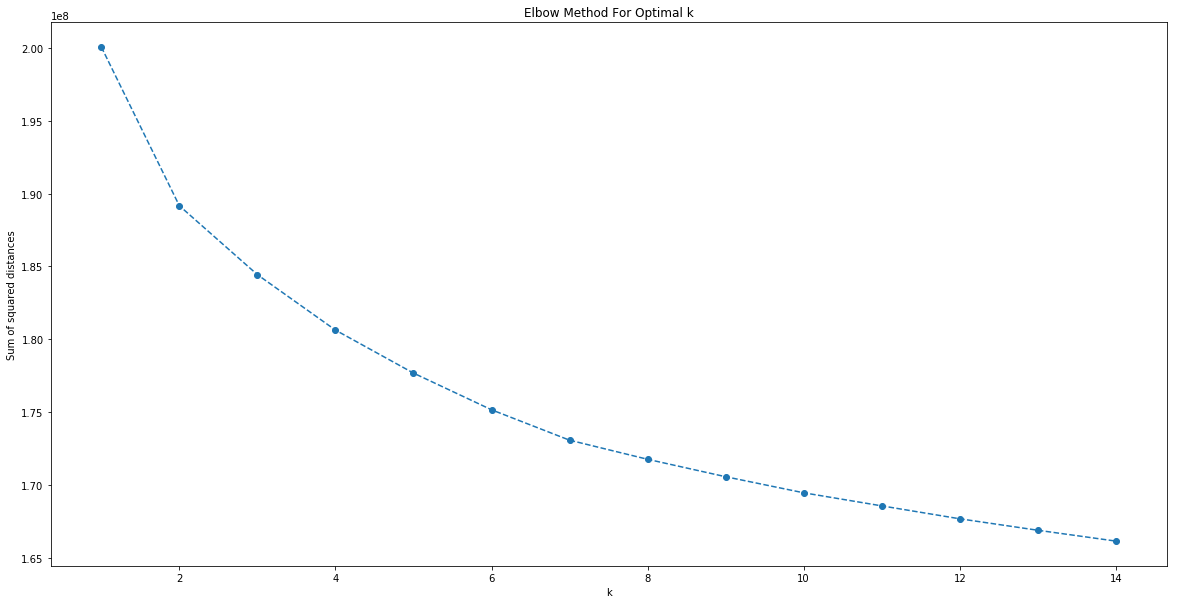

In [43]:
# plot to see elbow
plt.figure(figsize=(20,10))
plt.plot(K, Sum_of_squared_distances, 'o--')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')

There is an elbow at k=2. There is also a small elbow at k=7. 2 clusters may be too small so I prefer to use 7 clusters instead of 2.

#### 1.2.2. Clustering for k=7

In [25]:
# kmeans for clustering with n_clusters=7 and fit the model
km = KMeans(n_clusters=7)
km.fit(azdias_reduced)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [26]:
# predict azdias dataset
azdias_predicted = km.predict(azdias_reduced)

In [27]:
azdias_predicted.shape

(688741,)

In [28]:
# create dataframe for azdias_predicted
azdias_clustered=pd.DataFrame(azdias_predicted, columns=["cluster"])

In [29]:
# predict customer dataset
customer_predicted = km.predict(customer_reduced)

In [30]:
customer_predicted.shape

(121955,)

In [31]:
# create dataframe for customer_predicted
customer_clustered=pd.DataFrame(customer_predicted, columns=["cluster"])

In [32]:
# create dataframe of proportion of clusters for both dataset
clusters=pd.DataFrame(data={'azdias_clusters': (azdias_clustered["cluster"].value_counts().sort_index().values/azdias_clustered.shape[0]), 
 'customer_clusters': (customer_clustered["cluster"].value_counts().sort_index().values/customer_clustered.shape[0])})

In [33]:
clusters

,azdias_clusters,customer_clusters
0,0.144745,0.142700
1,0.132900,0.085122
2,0.181716,0.166807
3,0.169078,0.121545
4,0.106471,0.117388
5,0.107720,0.119823
6,0.157370,0.246616


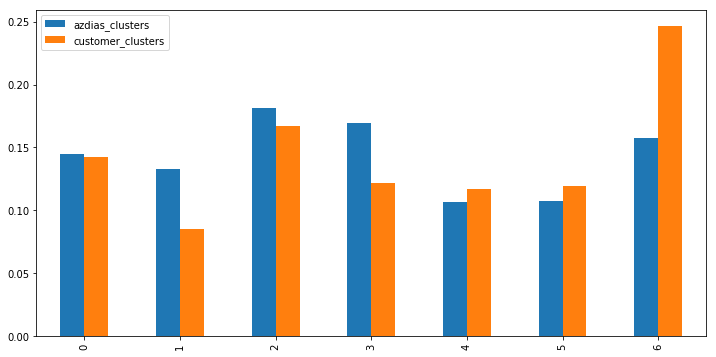

In [34]:
clusters.plot(kind="bar", figsize=[12,6])

***When we look at graph above, Cluster 1 is overrepresented. Cluster 3 and cluster 5 are underrepresented.***

#### 1.2.2. Avarerage feature values for each cluster

In [69]:
# create a dataframe by using inverse transform
cluster_clean=pd.DataFrame(scaler.inverse_transform(azdias_pca.inverse_transform(km.cluster_centers_)), 
                           columns=azdias_clean.columns)

In [36]:
cluster_clean

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
0,-0.505884,0.392519,0.135850,0.554518,0.784272,0.147785,0.000610,-0.257790,-3.516327e-16,0.544444,...,-0.052965,-0.257471,0.289589,0.179265,0.039451,-0.352896,-0.219197,0.666714,-0.700690,-0.093045
1,-0.173826,-0.521866,0.695358,0.298497,-0.506825,-0.121302,0.653452,1.123767,1.139614e-16,-0.428339,...,0.050939,0.603797,-0.239335,-1.225916,-0.916843,0.192282,0.230602,-0.609685,-0.119817,0.197971
2,0.556840,-0.381746,-0.247006,-0.676638,-0.503742,-0.120078,-0.214302,-0.042779,-1.725917e-16,-0.569285,...,0.020448,0.074474,-0.189854,0.105231,0.354100,0.270160,0.361460,-0.487347,0.670182,0.317544
3,-0.555279,0.454299,0.135340,0.619018,-0.223176,-0.086380,0.092189,-0.175390,1.169818e-16,-0.374695,...,-0.101677,-0.227322,-0.133000,0.138418,-0.198201,-0.295491,0.153888,0.361547,-0.772637,0.350307
4,0.099091,-0.030351,-0.129858,-0.149467,-0.031973,0.208561,-0.087655,-0.097147,-2.784960e-16,-0.072048,...,0.073316,-0.080730,0.284222,0.058883,0.090699,-0.027458,-0.636928,-0.158477,0.172972,0.336068
5,0.111515,-0.002796,-0.095097,-0.081391,0.154420,-0.001674,-0.124978,-0.148494,2.082012e-16,0.875779,...,0.058752,0.060277,-0.182419,0.038568,0.097303,0.025159,0.220815,0.186783,0.120285,-1.887431
6,0.422352,0.054831,-0.419425,-0.489054,0.444018,0.057967,-0.259151,-0.306710,3.467573e-16,0.370182,...,0.001500,-0.101477,0.230380,0.533949,0.414103,0.169101,-0.295930,0.055324,0.602579,0.239805


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### 2.1. Exploration of the train dataset

In [9]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [67]:
mailout_train.shape

(42962, 367)

In [36]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [12]:
# number of responses in response column
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

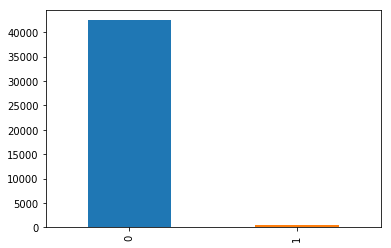

In [14]:
mailout_train['RESPONSE'].value_counts().plot(kind="bar")

As we can see bar chart above, there is a huge difference between response and no response. Our dataset is highly imbalanced.

***data_preprocessing function is modified related to response column. 
Outliers in response columns are not dropped and response column is not scaled.***

In [41]:
def data_preprocessing_2 (df, df_name = None):
    """
    data_preprocessing is modified related to response column. 
    Outliers in response columns are not dropped and response column is not scaled.
    
    Perform cleaning of demographics dataset by dropping missing columns and rows, reencoding, 
    completing missing values, and dropping correlated features
    
    Input: 
    df: Demographic dataset (DataFrame)
    df_name: Name of dataframe (str)
    
    Output:
    df_clean: Cleaned dataset (DataFrame)
    """
    # Get copy of df
    df_clean=df.copy()
    
    # Drop columns from customer dataset, which are not found in azdias dataset 
    if df_name=='customers':
        df_clean.drop(columns= ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    # Drop columns which involve too many missing values
    df_clean.drop(columns= ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP'], 
                  inplace=True)
    
    # Find the rows that include too many missing values and drop them if ratio of missing values more than 0.5
    df_row_nan_mean=df_clean.isnull().mean(axis=1)
    rows_to_drop=df_row_nan_mean[df_row_nan_mean>0.5].index
    df_clean.drop(rows_to_drop, inplace=True)
    
    # Remove the columns which involve too many features
    df_clean.drop(columns=["CAMEO_DEU_2015", "CAMEO_INTL_2015", "D19_LETZTER_KAUF_BRANCHE"], inplace=True)
    
    # Change dtype of EINGEFUEGT_AM column from object to datetime and extract only year
    df_clean["EINGEFUEGT_AM"]=pd.to_datetime(df_clean["EINGEFUEGT_AM"])
    df_clean["EINGEFUEGT_AM"]=pd.DatetimeIndex(df_clean["EINGEFUEGT_AM"]).year
    
    # Convert categorical column to encoded
    df_clean["CAMEO_DEUG_2015"]=pd.factorize(df_clean["CAMEO_DEUG_2015"])[0]
    
    # Convert categorical column to encoded
    df_clean=pd.get_dummies(df_clean, drop_first=True)
        
    # Impute missing values with mode value
    imputer = SimpleImputer(strategy='most_frequent')
    df_clean=pd.DataFrame(imputer.fit_transform(df_clean), columns = df_clean.columns)
    
    # Identify and remove 45 correlated features
    
    df_clean.drop(columns=['ANZ_STATISTISCHE_HAUSHALTE', 'CJT_TYP_2', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
    'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12',
    'D19_KONSUMTYP_MAX', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM',
    'D19_VERSAND_ONLINE_QUOTE_12', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3',
    'KBA05_SEG2', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG9', 'KBA05_ZUL4', 'KBA13_HALTER_40', 'KBA13_HALTER_55',
    'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'KBA13_KMH_250', 'KBA13_SITZE_5', 'KBA13_VW', 'LP_FAMILIE_GROB',
    'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB', 'MIN_GEBAEUDEJAHR', 'ORTSGR_KLS9', 'PLZ8_ANTG1',
    'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'VK_DISTANZ', 'VK_ZG11', 'ANREDE_KZ'], inplace=True)
    
    if "RESPONSE" in df_clean.columns:
        
        # Remove outliers from dataset by using z score
        z = np.abs(stats.zscore(df_clean.drop(columns=['RESPONSE'])))
        df_clean = df_clean[(z < 6).all(axis=1)]
        df_clean.reset_index(drop=True, inplace=True)
        
        # Standardization of dataset
        lnr=df_clean['LNR']
        response=df_clean['RESPONSE']
        scaler = StandardScaler()    
        df_clean=pd.DataFrame(scaler.fit_transform(df_clean), columns = df_clean.columns)
        df_clean['RESPONSE']=response
        df_clean['LNR']=lnr
        
        
    else:
        # Remove outliers from dataset by using z score
        z = np.abs(stats.zscore(df_clean))
        df_clean = df_clean[(z < 6).all(axis=1)]
        df_clean.reset_index(drop=True, inplace=True)

        # Standardization of dataset
        lnr=df_clean['LNR']
        scaler = StandardScaler()
        df_clean=pd.DataFrame(scaler.fit_transform(df_clean), columns = df_clean.columns)
        df_clean['LNR']=lnr
   
    # set index LNR column
    df_clean.set_index("LNR", inplace=True)

    return df_clean

In [42]:
# preprocessing of train dataset
mailout_train_clean = data_preprocessing_2(mailout_train)

In [43]:
mailout_train.shape

(42962, 367)

In [44]:
mailout_train_clean.shape

(30506, 312)

In [45]:
# number of responses in response column in cleaned train data
mailout_train_clean["RESPONSE"].value_counts()

0.0    30126
1.0      380
Name: RESPONSE, dtype: int64

### 2.2. Modelling

In [46]:
X = mailout_train_clean.drop(columns=['RESPONSE'])
y= mailout_train_clean['RESPONSE']

In [47]:
# spliting dataset as train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

It is requested to get probabilities rather than labels. So, we will use regression models instead of classification models.

#### 2.2.1. AUC-ROC XGBRegressor model

In [52]:
# fitting XGBRegressor model with train dataset
eval_set = [(X_train, y_train), (X_test, y_test)]
clf_reg = xgb.XGBRegressor(n_estimators=200, learning_rate=0.01)
clf_reg.fit(X_train, y_train, eval_set=eval_set,
          eval_metric="auc", verbose=True, early_stopping_rounds=100)

[0]	validation_0-auc:0.80076	validation_1-auc:0.76644
[1]	validation_0-auc:0.80082	validation_1-auc:0.76646
[2]	validation_0-auc:0.80527	validation_1-auc:0.76670
[3]	validation_0-auc:0.81083	validation_1-auc:0.76171
[4]	validation_0-auc:0.81090	validation_1-auc:0.76200
[5]	validation_0-auc:0.81129	validation_1-auc:0.76162
[6]	validation_0-auc:0.81330	validation_1-auc:0.76060
[7]	validation_0-auc:0.81228	validation_1-auc:0.76109
[8]	validation_0-auc:0.81364	validation_1-auc:0.76078
[9]	validation_0-auc:0.81489	validation_1-auc:0.75926
[10]	validation_0-auc:0.81683	validation_1-auc:0.75979
[11]	validation_0-auc:0.81654	validation_1-auc:0.76045
[12]	validation_0-auc:0.81764	validation_1-auc:0.76128
[13]	validation_0-auc:0.81900	validation_1-auc:0.76000
[14]	validation_0-auc:0.82044	validation_1-auc:0.76032
[15]	validation_0-auc:0.82050	validation_1-auc:0.76074
[16]	validation_0-auc:0.82135	validation_1-auc:0.76348
[17]	validation_0-auc:0.82146	validation_1-auc:0.76284
[18]	validation_0-au

[149]	validation_0-auc:0.94997	validation_1-auc:0.79353
[150]	validation_0-auc:0.95281	validation_1-auc:0.79734
[151]	validation_0-auc:0.95333	validation_1-auc:0.79647
[152]	validation_0-auc:0.95476	validation_1-auc:0.79887
[153]	validation_0-auc:0.95641	validation_1-auc:0.79898
[154]	validation_0-auc:0.95735	validation_1-auc:0.79844
[155]	validation_0-auc:0.95840	validation_1-auc:0.79908
[156]	validation_0-auc:0.95889	validation_1-auc:0.79911
[157]	validation_0-auc:0.95983	validation_1-auc:0.79870
[158]	validation_0-auc:0.96035	validation_1-auc:0.79930
[159]	validation_0-auc:0.96103	validation_1-auc:0.79909
[160]	validation_0-auc:0.96145	validation_1-auc:0.79824
[161]	validation_0-auc:0.96200	validation_1-auc:0.79849
[162]	validation_0-auc:0.96240	validation_1-auc:0.79791
[163]	validation_0-auc:0.96281	validation_1-auc:0.79795
[164]	validation_0-auc:0.96320	validation_1-auc:0.79780
[165]	validation_0-auc:0.96362	validation_1-auc:0.79795
[166]	validation_0-auc:0.96422	validation_1-auc:

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
# roc_auc score for train data
roc_auc_score(y_train, clf_reg.predict(X_train))

0.9603476105302224

In [55]:
# roc_auc score for test data
roc_auc_score(y_test, clf_reg.predict(X_test))

0.7992981921197827

#### 2.2.2. AUC-ROC Curve

In [56]:
def plot_roc_curve(classifier, X_train, X_test, y_train, y_test):
    """
    Plot train and test roc curve for the classifier 
    
    Input: 
    X_train, X_test: Train and test dataset (DataFrame)
    y_train, y_test: Train and test labels (array)
    
    Output:
    return None
    """
    # predicted values for train and test datasets
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    
    # False positive and true positive rates calculation for predicted values
    fpr_train, tpr_train, _train = roc_curve(y_train,  y_pred_train)
    fpr_test, tpr_test, _test = roc_curve(y_test,  y_pred_test)
    
    # calculation of auc scores
    auc_train = round(roc_auc_score(y_train, y_pred_train),2)
    auc_test = round(roc_auc_score(y_test, y_pred_test),2)
      
    # plot
    plt.plot(fpr_train, tpr_train, label="Train ROC curve area = "+ str(auc_train))
    plt.plot(fpr_test, tpr_test, label="Test ROC curve area = "+ str(auc_test))
    
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')

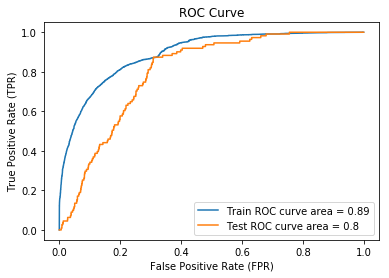

In [57]:
plot_roc_curve(clf_reg, X_train_sm, X_test, y_train_sm, y_test)

#### 2.2.3. Feature importance

We can see most important features by using plot_importance of xgboost. First 20 features are plotted in bar graph.

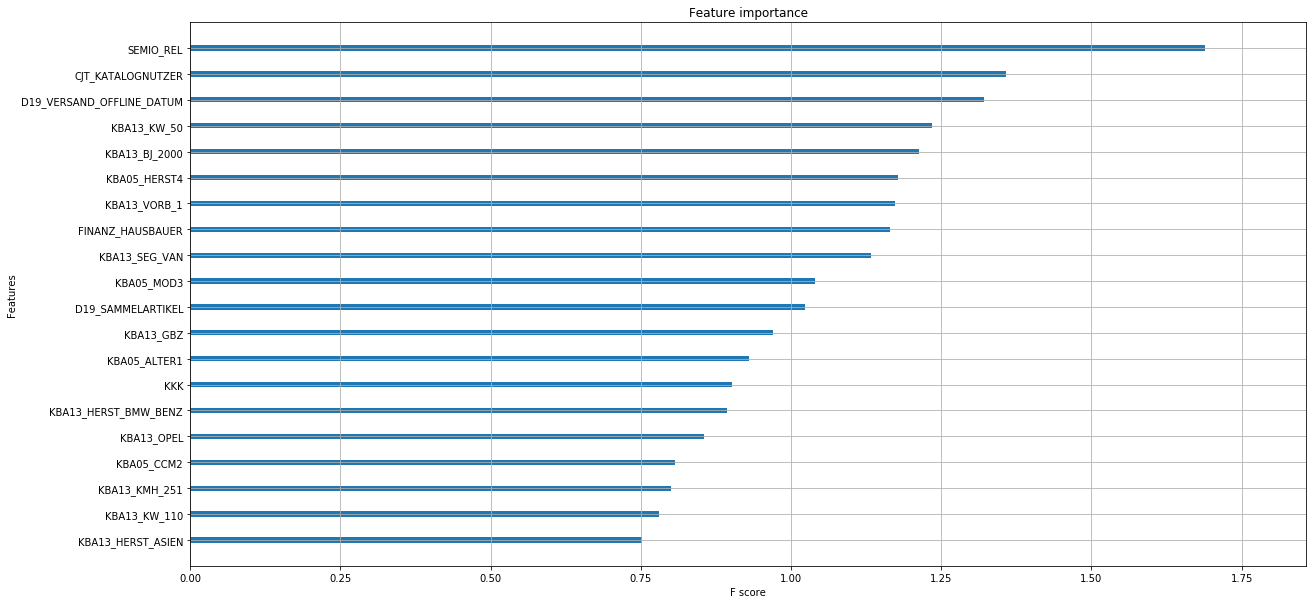

In [58]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_importance(clf_reg, ax=ax, importance_type="gain", max_num_features=20, show_values=False, grid=True) 
#importance_type=[‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

#### 2.2.4. Fine tunning by using random search

RandomizedSearchCV from sklearn selects random combinations and mostly it finds best parameters in shorter time than grid search which is exhaustive search over specified parameters.

In [104]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [79]:
# create model with certain parameters
xgb_reg2 = xgb.XGBRegressor(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [112]:
# create random search with the model in roc auc score and wtih 4-fold cross validation
random_search = RandomizedSearchCV(xgb_reg2, params, scoring='roc_auc', cv=4)

# fitting model
random_search.fit(X, y, eval_set=eval_set, eval_metric="auc", verbose=True, early_stopping_rounds=30)

[04:58:55] WARNING: xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.75819	validation_1-auc:0.77160
[1]	validation_0-auc:0.75819	validation_1-auc:0.77160
[2]	validation_0-auc:0.75819	validation_1-auc:0.77160
[3]	validation_0-auc:0.75763	validation_1-auc:0.77247
[4]	validation_0-auc:0.75763	validation_1-auc:0.77247
[5]	validation_0-auc:0.75763	validation_1-auc:0.77247
[6]	validation_0-auc:0.75763	validation_1-auc:0.77247
[7]	validation_0-auc:0.75763	validation_1-auc:0.77247
[8]	validation_0-auc:0.75880	validation_1-auc:0.77519
[9]	validation_0-auc:0.75880	validation_1-auc:0.77519
[10]	validation_0-auc:0.76073	validation_1-auc:0.77958
[11]	validation_0-auc:0.76077	validation_1-auc:0.77967
[12]	validation_0-a

[143]	validation_0-auc:0.79076	validation_1-auc:0.82625
[144]	validation_0-auc:0.79039	validation_1-auc:0.82611
[145]	validation_0-auc:0.79130	validation_1-auc:0.82611
[146]	validation_0-auc:0.79277	validation_1-auc:0.83126
[147]	validation_0-auc:0.79285	validation_1-auc:0.83170
[148]	validation_0-auc:0.79325	validation_1-auc:0.83369
[149]	validation_0-auc:0.79343	validation_1-auc:0.83442
[150]	validation_0-auc:0.79385	validation_1-auc:0.83349
[151]	validation_0-auc:0.79507	validation_1-auc:0.83466
[152]	validation_0-auc:0.79578	validation_1-auc:0.83465
[153]	validation_0-auc:0.79675	validation_1-auc:0.83576
[154]	validation_0-auc:0.79672	validation_1-auc:0.83638
[155]	validation_0-auc:0.79688	validation_1-auc:0.83751
[156]	validation_0-auc:0.79766	validation_1-auc:0.83702
[157]	validation_0-auc:0.79735	validation_1-auc:0.83760
[158]	validation_0-auc:0.79853	validation_1-auc:0.83855
[159]	validation_0-auc:0.79901	validation_1-auc:0.83928
[160]	validation_0-auc:0.80033	validation_1-auc:

[290]	validation_0-auc:0.85996	validation_1-auc:0.89741
[291]	validation_0-auc:0.86041	validation_1-auc:0.89773
[292]	validation_0-auc:0.86043	validation_1-auc:0.89844
[293]	validation_0-auc:0.86054	validation_1-auc:0.89931
[294]	validation_0-auc:0.86073	validation_1-auc:0.89932
[295]	validation_0-auc:0.86044	validation_1-auc:0.90018
[296]	validation_0-auc:0.86061	validation_1-auc:0.90055
[297]	validation_0-auc:0.86125	validation_1-auc:0.90098
[298]	validation_0-auc:0.86125	validation_1-auc:0.90150
[299]	validation_0-auc:0.86188	validation_1-auc:0.90217
[300]	validation_0-auc:0.86231	validation_1-auc:0.90253
[301]	validation_0-auc:0.86285	validation_1-auc:0.90356
[302]	validation_0-auc:0.86291	validation_1-auc:0.90412
[303]	validation_0-auc:0.86286	validation_1-auc:0.90415
[304]	validation_0-auc:0.86321	validation_1-auc:0.90420
[305]	validation_0-auc:0.86359	validation_1-auc:0.90442
[306]	validation_0-auc:0.86382	validation_1-auc:0.90446
[307]	validation_0-auc:0.86392	validation_1-auc:

[437]	validation_0-auc:0.89225	validation_1-auc:0.93222
[438]	validation_0-auc:0.89225	validation_1-auc:0.93233
[439]	validation_0-auc:0.89235	validation_1-auc:0.93223
[440]	validation_0-auc:0.89264	validation_1-auc:0.93240
[441]	validation_0-auc:0.89275	validation_1-auc:0.93246
[442]	validation_0-auc:0.89260	validation_1-auc:0.93251
[443]	validation_0-auc:0.89251	validation_1-auc:0.93249
[444]	validation_0-auc:0.89272	validation_1-auc:0.93243
[445]	validation_0-auc:0.89291	validation_1-auc:0.93239
[446]	validation_0-auc:0.89316	validation_1-auc:0.93247
[447]	validation_0-auc:0.89318	validation_1-auc:0.93242
[448]	validation_0-auc:0.89364	validation_1-auc:0.93260
[449]	validation_0-auc:0.89373	validation_1-auc:0.93292
[450]	validation_0-auc:0.89428	validation_1-auc:0.93303
[451]	validation_0-auc:0.89449	validation_1-auc:0.93337
[452]	validation_0-auc:0.89454	validation_1-auc:0.93363
[453]	validation_0-auc:0.89486	validation_1-auc:0.93390
[454]	validation_0-auc:0.89499	validation_1-auc:

[584]	validation_0-auc:0.91196	validation_1-auc:0.94161
[585]	validation_0-auc:0.91212	validation_1-auc:0.94176
[586]	validation_0-auc:0.91213	validation_1-auc:0.94181
[587]	validation_0-auc:0.91212	validation_1-auc:0.94180
[588]	validation_0-auc:0.91234	validation_1-auc:0.94176
[589]	validation_0-auc:0.91234	validation_1-auc:0.94180
[590]	validation_0-auc:0.91250	validation_1-auc:0.94190
[591]	validation_0-auc:0.91267	validation_1-auc:0.94187
[592]	validation_0-auc:0.91304	validation_1-auc:0.94176
[593]	validation_0-auc:0.91299	validation_1-auc:0.94177
[594]	validation_0-auc:0.91309	validation_1-auc:0.94183
[595]	validation_0-auc:0.91322	validation_1-auc:0.94184
[596]	validation_0-auc:0.91321	validation_1-auc:0.94185
[597]	validation_0-auc:0.91331	validation_1-auc:0.94187
[598]	validation_0-auc:0.91354	validation_1-auc:0.94173
[599]	validation_0-auc:0.91366	validation_1-auc:0.94179
[05:02:49] WARNING: xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may n

[127]	validation_0-auc:0.78201	validation_1-auc:0.84376
[128]	validation_0-auc:0.78619	validation_1-auc:0.84300
[129]	validation_0-auc:0.78596	validation_1-auc:0.84297
[130]	validation_0-auc:0.78538	validation_1-auc:0.84340
[131]	validation_0-auc:0.78563	validation_1-auc:0.84319
[132]	validation_0-auc:0.78607	validation_1-auc:0.84250
[133]	validation_0-auc:0.78575	validation_1-auc:0.84225
[134]	validation_0-auc:0.78605	validation_1-auc:0.84284
[135]	validation_0-auc:0.78555	validation_1-auc:0.84303
[136]	validation_0-auc:0.78571	validation_1-auc:0.84311
[137]	validation_0-auc:0.78567	validation_1-auc:0.84348
[138]	validation_0-auc:0.78812	validation_1-auc:0.84809
[139]	validation_0-auc:0.78867	validation_1-auc:0.84771
[140]	validation_0-auc:0.78933	validation_1-auc:0.84721
[141]	validation_0-auc:0.78989	validation_1-auc:0.85169
[142]	validation_0-auc:0.79099	validation_1-auc:0.85251
[143]	validation_0-auc:0.79167	validation_1-auc:0.85316
[144]	validation_0-auc:0.79173	validation_1-auc:

[274]	validation_0-auc:0.85059	validation_1-auc:0.89817
[275]	validation_0-auc:0.85073	validation_1-auc:0.89848
[276]	validation_0-auc:0.85106	validation_1-auc:0.89860
[277]	validation_0-auc:0.85179	validation_1-auc:0.89877
[278]	validation_0-auc:0.85196	validation_1-auc:0.89900
[279]	validation_0-auc:0.85265	validation_1-auc:0.89951
[280]	validation_0-auc:0.85287	validation_1-auc:0.89986
[281]	validation_0-auc:0.85331	validation_1-auc:0.90058
[282]	validation_0-auc:0.85335	validation_1-auc:0.90074
[283]	validation_0-auc:0.85379	validation_1-auc:0.90076
[284]	validation_0-auc:0.85379	validation_1-auc:0.90104
[285]	validation_0-auc:0.85503	validation_1-auc:0.90107
[286]	validation_0-auc:0.85622	validation_1-auc:0.90127
[287]	validation_0-auc:0.85613	validation_1-auc:0.90143
[288]	validation_0-auc:0.85660	validation_1-auc:0.90138
[289]	validation_0-auc:0.85668	validation_1-auc:0.90146
[290]	validation_0-auc:0.85724	validation_1-auc:0.90179
[291]	validation_0-auc:0.85755	validation_1-auc:

[421]	validation_0-auc:0.89155	validation_1-auc:0.92799
[422]	validation_0-auc:0.89194	validation_1-auc:0.92782
[423]	validation_0-auc:0.89210	validation_1-auc:0.92784
[424]	validation_0-auc:0.89244	validation_1-auc:0.92808
[425]	validation_0-auc:0.89291	validation_1-auc:0.92811
[426]	validation_0-auc:0.89343	validation_1-auc:0.92838
[427]	validation_0-auc:0.89373	validation_1-auc:0.92841
[428]	validation_0-auc:0.89386	validation_1-auc:0.92844
[429]	validation_0-auc:0.89423	validation_1-auc:0.92852
[430]	validation_0-auc:0.89415	validation_1-auc:0.92882
[431]	validation_0-auc:0.89401	validation_1-auc:0.92876
[432]	validation_0-auc:0.89419	validation_1-auc:0.92865
[433]	validation_0-auc:0.89464	validation_1-auc:0.92855
[434]	validation_0-auc:0.89484	validation_1-auc:0.92874
[435]	validation_0-auc:0.89495	validation_1-auc:0.92901
[436]	validation_0-auc:0.89530	validation_1-auc:0.92910
[437]	validation_0-auc:0.89521	validation_1-auc:0.92916
[438]	validation_0-auc:0.89517	validation_1-auc:

[12]	validation_0-auc:0.76180	validation_1-auc:0.77794
[13]	validation_0-auc:0.76180	validation_1-auc:0.77794
[14]	validation_0-auc:0.76221	validation_1-auc:0.77789
[15]	validation_0-auc:0.76059	validation_1-auc:0.78808
[16]	validation_0-auc:0.75797	validation_1-auc:0.79604
[17]	validation_0-auc:0.75811	validation_1-auc:0.79602
[18]	validation_0-auc:0.75833	validation_1-auc:0.79600
[19]	validation_0-auc:0.75786	validation_1-auc:0.79734
[20]	validation_0-auc:0.75792	validation_1-auc:0.79740
[21]	validation_0-auc:0.75791	validation_1-auc:0.79739
[22]	validation_0-auc:0.75791	validation_1-auc:0.79740
[23]	validation_0-auc:0.75790	validation_1-auc:0.79740
[24]	validation_0-auc:0.75780	validation_1-auc:0.79744
[25]	validation_0-auc:0.77601	validation_1-auc:0.80157
[26]	validation_0-auc:0.77601	validation_1-auc:0.80157
[27]	validation_0-auc:0.78093	validation_1-auc:0.80300
[28]	validation_0-auc:0.78093	validation_1-auc:0.80300
[29]	validation_0-auc:0.77955	validation_1-auc:0.80044
[30]	valid

[160]	validation_0-auc:0.81693	validation_1-auc:0.86688
[161]	validation_0-auc:0.81726	validation_1-auc:0.86735
[162]	validation_0-auc:0.81793	validation_1-auc:0.86661
[163]	validation_0-auc:0.81779	validation_1-auc:0.86647
[164]	validation_0-auc:0.81838	validation_1-auc:0.86839
[165]	validation_0-auc:0.81838	validation_1-auc:0.86922
[166]	validation_0-auc:0.81887	validation_1-auc:0.86936
[167]	validation_0-auc:0.81889	validation_1-auc:0.86951
[168]	validation_0-auc:0.81816	validation_1-auc:0.86924
[169]	validation_0-auc:0.81748	validation_1-auc:0.87017
[170]	validation_0-auc:0.81804	validation_1-auc:0.87001
[171]	validation_0-auc:0.81907	validation_1-auc:0.87063
[172]	validation_0-auc:0.81898	validation_1-auc:0.87125
[173]	validation_0-auc:0.82025	validation_1-auc:0.87151
[174]	validation_0-auc:0.82122	validation_1-auc:0.87209
[175]	validation_0-auc:0.82139	validation_1-auc:0.87195
[176]	validation_0-auc:0.82153	validation_1-auc:0.87172
[177]	validation_0-auc:0.82249	validation_1-auc:

[307]	validation_0-auc:0.87562	validation_1-auc:0.93187
[308]	validation_0-auc:0.87536	validation_1-auc:0.93203
[309]	validation_0-auc:0.87579	validation_1-auc:0.93204
[310]	validation_0-auc:0.87551	validation_1-auc:0.93264
[311]	validation_0-auc:0.87552	validation_1-auc:0.93228
[312]	validation_0-auc:0.87572	validation_1-auc:0.93283
[313]	validation_0-auc:0.87612	validation_1-auc:0.93294
[314]	validation_0-auc:0.87619	validation_1-auc:0.93368
[315]	validation_0-auc:0.87678	validation_1-auc:0.93399
[316]	validation_0-auc:0.87682	validation_1-auc:0.93399
[317]	validation_0-auc:0.87697	validation_1-auc:0.93434
[318]	validation_0-auc:0.87707	validation_1-auc:0.93515
[319]	validation_0-auc:0.87752	validation_1-auc:0.93550
[320]	validation_0-auc:0.87787	validation_1-auc:0.93545
[321]	validation_0-auc:0.87806	validation_1-auc:0.93578
[322]	validation_0-auc:0.87818	validation_1-auc:0.93622
[323]	validation_0-auc:0.87892	validation_1-auc:0.93648
[324]	validation_0-auc:0.87935	validation_1-auc:

[454]	validation_0-auc:0.90741	validation_1-auc:0.95279
[455]	validation_0-auc:0.90744	validation_1-auc:0.95278
[456]	validation_0-auc:0.90744	validation_1-auc:0.95298
[457]	validation_0-auc:0.90761	validation_1-auc:0.95323
[458]	validation_0-auc:0.90794	validation_1-auc:0.95319
[459]	validation_0-auc:0.90814	validation_1-auc:0.95347
[460]	validation_0-auc:0.90847	validation_1-auc:0.95346
[461]	validation_0-auc:0.90873	validation_1-auc:0.95362
[462]	validation_0-auc:0.90891	validation_1-auc:0.95359
[463]	validation_0-auc:0.90913	validation_1-auc:0.95385
[464]	validation_0-auc:0.90929	validation_1-auc:0.95407
[465]	validation_0-auc:0.90931	validation_1-auc:0.95405
[466]	validation_0-auc:0.90944	validation_1-auc:0.95408
[467]	validation_0-auc:0.90973	validation_1-auc:0.95408
[468]	validation_0-auc:0.90986	validation_1-auc:0.95407
[469]	validation_0-auc:0.91025	validation_1-auc:0.95428
[470]	validation_0-auc:0.91050	validation_1-auc:0.95428
[471]	validation_0-auc:0.91068	validation_1-auc:

[0]	validation_0-auc:0.76155	validation_1-auc:0.78059
[1]	validation_0-auc:0.76155	validation_1-auc:0.78059
[2]	validation_0-auc:0.75823	validation_1-auc:0.77446
[3]	validation_0-auc:0.75823	validation_1-auc:0.77446
[4]	validation_0-auc:0.75823	validation_1-auc:0.77446
[5]	validation_0-auc:0.76155	validation_1-auc:0.78059
[6]	validation_0-auc:0.76155	validation_1-auc:0.78059
[7]	validation_0-auc:0.75823	validation_1-auc:0.77446
[8]	validation_0-auc:0.75823	validation_1-auc:0.77446
[9]	validation_0-auc:0.75823	validation_1-auc:0.77446
[10]	validation_0-auc:0.75823	validation_1-auc:0.77446
[11]	validation_0-auc:0.78205	validation_1-auc:0.77942
[12]	validation_0-auc:0.78205	validation_1-auc:0.77942
[13]	validation_0-auc:0.78205	validation_1-auc:0.77942
[14]	validation_0-auc:0.78161	validation_1-auc:0.77892
[15]	validation_0-auc:0.78161	validation_1-auc:0.77892
[16]	validation_0-auc:0.79069	validation_1-auc:0.79254
[17]	validation_0-auc:0.79069	validation_1-auc:0.79254
[18]	validation_0-au

[149]	validation_0-auc:0.81277	validation_1-auc:0.86169
[150]	validation_0-auc:0.81240	validation_1-auc:0.86196
[151]	validation_0-auc:0.81227	validation_1-auc:0.86459
[152]	validation_0-auc:0.81209	validation_1-auc:0.86459
[153]	validation_0-auc:0.81247	validation_1-auc:0.86452
[154]	validation_0-auc:0.81225	validation_1-auc:0.86430
[155]	validation_0-auc:0.81265	validation_1-auc:0.86395
[156]	validation_0-auc:0.81316	validation_1-auc:0.86431
[157]	validation_0-auc:0.81294	validation_1-auc:0.86413
[158]	validation_0-auc:0.81323	validation_1-auc:0.86397
[159]	validation_0-auc:0.81360	validation_1-auc:0.86504
[160]	validation_0-auc:0.81353	validation_1-auc:0.86638
[161]	validation_0-auc:0.81356	validation_1-auc:0.86618
[162]	validation_0-auc:0.81369	validation_1-auc:0.86682
[163]	validation_0-auc:0.81408	validation_1-auc:0.86662
[164]	validation_0-auc:0.81591	validation_1-auc:0.86854
[165]	validation_0-auc:0.81646	validation_1-auc:0.86937
[166]	validation_0-auc:0.81693	validation_1-auc:

[296]	validation_0-auc:0.86856	validation_1-auc:0.91339
[297]	validation_0-auc:0.86880	validation_1-auc:0.91385
[298]	validation_0-auc:0.86897	validation_1-auc:0.91399
[299]	validation_0-auc:0.86915	validation_1-auc:0.91396
[300]	validation_0-auc:0.86953	validation_1-auc:0.91470
[301]	validation_0-auc:0.87020	validation_1-auc:0.91552
[302]	validation_0-auc:0.87037	validation_1-auc:0.91589
[303]	validation_0-auc:0.87121	validation_1-auc:0.91662
[304]	validation_0-auc:0.87150	validation_1-auc:0.91704
[305]	validation_0-auc:0.87202	validation_1-auc:0.91715
[306]	validation_0-auc:0.87217	validation_1-auc:0.91733
[307]	validation_0-auc:0.87294	validation_1-auc:0.91745
[308]	validation_0-auc:0.87296	validation_1-auc:0.91752
[309]	validation_0-auc:0.87295	validation_1-auc:0.91699
[310]	validation_0-auc:0.87320	validation_1-auc:0.91717
[311]	validation_0-auc:0.87400	validation_1-auc:0.91729
[312]	validation_0-auc:0.87478	validation_1-auc:0.91741
[313]	validation_0-auc:0.87549	validation_1-auc:

[443]	validation_0-auc:0.91373	validation_1-auc:0.94226
[444]	validation_0-auc:0.91426	validation_1-auc:0.94212
[445]	validation_0-auc:0.91449	validation_1-auc:0.94247
[446]	validation_0-auc:0.91492	validation_1-auc:0.94238
[447]	validation_0-auc:0.91523	validation_1-auc:0.94241
[448]	validation_0-auc:0.91536	validation_1-auc:0.94232
[449]	validation_0-auc:0.91549	validation_1-auc:0.94258
[450]	validation_0-auc:0.91565	validation_1-auc:0.94279
[451]	validation_0-auc:0.91599	validation_1-auc:0.94280
[452]	validation_0-auc:0.91617	validation_1-auc:0.94276
[453]	validation_0-auc:0.91624	validation_1-auc:0.94285
[454]	validation_0-auc:0.91622	validation_1-auc:0.94287
[455]	validation_0-auc:0.91623	validation_1-auc:0.94297
[456]	validation_0-auc:0.91633	validation_1-auc:0.94308
[457]	validation_0-auc:0.91651	validation_1-auc:0.94317
[458]	validation_0-auc:0.91674	validation_1-auc:0.94312
[459]	validation_0-auc:0.91710	validation_1-auc:0.94312
[460]	validation_0-auc:0.91751	validation_1-auc:

[590]	validation_0-auc:0.93756	validation_1-auc:0.95117
[591]	validation_0-auc:0.93758	validation_1-auc:0.95128
[592]	validation_0-auc:0.93757	validation_1-auc:0.95135
[593]	validation_0-auc:0.93778	validation_1-auc:0.95140
[594]	validation_0-auc:0.93794	validation_1-auc:0.95137
[595]	validation_0-auc:0.93810	validation_1-auc:0.95148
[596]	validation_0-auc:0.93825	validation_1-auc:0.95149
[597]	validation_0-auc:0.93833	validation_1-auc:0.95148
[598]	validation_0-auc:0.93836	validation_1-auc:0.95167
[599]	validation_0-auc:0.93848	validation_1-auc:0.95170
[05:14:10] WARNING: xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.76180	validation_1-auc:0.77794
[

[17]	validation_0-auc:0.75848	validation_1-auc:0.77181
[18]	validation_0-auc:0.75848	validation_1-auc:0.77181
[19]	validation_0-auc:0.75848	validation_1-auc:0.77181
[20]	validation_0-auc:0.75848	validation_1-auc:0.77181
[21]	validation_0-auc:0.78230	validation_1-auc:0.77677
[22]	validation_0-auc:0.78230	validation_1-auc:0.77677
[23]	validation_0-auc:0.78230	validation_1-auc:0.77677
[24]	validation_0-auc:0.78230	validation_1-auc:0.77677
[25]	validation_0-auc:0.78230	validation_1-auc:0.77677
[26]	validation_0-auc:0.78230	validation_1-auc:0.77677
[27]	validation_0-auc:0.78230	validation_1-auc:0.77677
[28]	validation_0-auc:0.78230	validation_1-auc:0.77677
[29]	validation_0-auc:0.78230	validation_1-auc:0.77677
[30]	validation_0-auc:0.78230	validation_1-auc:0.77677
[05:14:50] WARNING: xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameter

[129]	validation_0-auc:0.78483	validation_1-auc:0.83872
[130]	validation_0-auc:0.78595	validation_1-auc:0.84110
[131]	validation_0-auc:0.78635	validation_1-auc:0.84177
[132]	validation_0-auc:0.78714	validation_1-auc:0.84393
[133]	validation_0-auc:0.78853	validation_1-auc:0.84379
[134]	validation_0-auc:0.78920	validation_1-auc:0.84458
[135]	validation_0-auc:0.78834	validation_1-auc:0.84614
[136]	validation_0-auc:0.79029	validation_1-auc:0.84559
[137]	validation_0-auc:0.79234	validation_1-auc:0.84506
[138]	validation_0-auc:0.79175	validation_1-auc:0.84605
[139]	validation_0-auc:0.79175	validation_1-auc:0.84654
[140]	validation_0-auc:0.79141	validation_1-auc:0.84760
[141]	validation_0-auc:0.79304	validation_1-auc:0.84771
[142]	validation_0-auc:0.79344	validation_1-auc:0.84739
[143]	validation_0-auc:0.79381	validation_1-auc:0.84735
[144]	validation_0-auc:0.79412	validation_1-auc:0.84797
[145]	validation_0-auc:0.79391	validation_1-auc:0.84849
[146]	validation_0-auc:0.79342	validation_1-auc:

[276]	validation_0-auc:0.85044	validation_1-auc:0.89865
[277]	validation_0-auc:0.85016	validation_1-auc:0.89875
[278]	validation_0-auc:0.85038	validation_1-auc:0.89867
[279]	validation_0-auc:0.85130	validation_1-auc:0.89913
[280]	validation_0-auc:0.85178	validation_1-auc:0.89909
[281]	validation_0-auc:0.85257	validation_1-auc:0.89955
[282]	validation_0-auc:0.85355	validation_1-auc:0.90037
[283]	validation_0-auc:0.85333	validation_1-auc:0.90019
[284]	validation_0-auc:0.85466	validation_1-auc:0.90104
[285]	validation_0-auc:0.85495	validation_1-auc:0.90144
[286]	validation_0-auc:0.85529	validation_1-auc:0.90212
[287]	validation_0-auc:0.85549	validation_1-auc:0.90229
[288]	validation_0-auc:0.85562	validation_1-auc:0.90215
[289]	validation_0-auc:0.85608	validation_1-auc:0.90261
[290]	validation_0-auc:0.85602	validation_1-auc:0.90287
[291]	validation_0-auc:0.85628	validation_1-auc:0.90307
[292]	validation_0-auc:0.85673	validation_1-auc:0.90347
[293]	validation_0-auc:0.85667	validation_1-auc:

[423]	validation_0-auc:0.88627	validation_1-auc:0.93040
[424]	validation_0-auc:0.88650	validation_1-auc:0.93079
[425]	validation_0-auc:0.88665	validation_1-auc:0.93095
[426]	validation_0-auc:0.88687	validation_1-auc:0.93095
[427]	validation_0-auc:0.88738	validation_1-auc:0.93133
[428]	validation_0-auc:0.88792	validation_1-auc:0.93155
[429]	validation_0-auc:0.88804	validation_1-auc:0.93166
[430]	validation_0-auc:0.88843	validation_1-auc:0.93196
[431]	validation_0-auc:0.88847	validation_1-auc:0.93206
[432]	validation_0-auc:0.88828	validation_1-auc:0.93203
[433]	validation_0-auc:0.88859	validation_1-auc:0.93254
[434]	validation_0-auc:0.88890	validation_1-auc:0.93273
[435]	validation_0-auc:0.88930	validation_1-auc:0.93306
[436]	validation_0-auc:0.88920	validation_1-auc:0.93344
[437]	validation_0-auc:0.88947	validation_1-auc:0.93316
[438]	validation_0-auc:0.88954	validation_1-auc:0.93307
[439]	validation_0-auc:0.88961	validation_1-auc:0.93315
[440]	validation_0-auc:0.88953	validation_1-auc:

[570]	validation_0-auc:0.91055	validation_1-auc:0.94278
[571]	validation_0-auc:0.91068	validation_1-auc:0.94310
[572]	validation_0-auc:0.91075	validation_1-auc:0.94344
[573]	validation_0-auc:0.91098	validation_1-auc:0.94327
[574]	validation_0-auc:0.91101	validation_1-auc:0.94347
[575]	validation_0-auc:0.91123	validation_1-auc:0.94348
[576]	validation_0-auc:0.91138	validation_1-auc:0.94383
[577]	validation_0-auc:0.91163	validation_1-auc:0.94372
[578]	validation_0-auc:0.91171	validation_1-auc:0.94403
[579]	validation_0-auc:0.91173	validation_1-auc:0.94424
[580]	validation_0-auc:0.91173	validation_1-auc:0.94431
[581]	validation_0-auc:0.91178	validation_1-auc:0.94453
[582]	validation_0-auc:0.91185	validation_1-auc:0.94457
[583]	validation_0-auc:0.91173	validation_1-auc:0.94450
[584]	validation_0-auc:0.91187	validation_1-auc:0.94459
[585]	validation_0-auc:0.91208	validation_1-auc:0.94495
[586]	validation_0-auc:0.91240	validation_1-auc:0.94522
[587]	validation_0-auc:0.91276	validation_1-auc:

[113]	validation_0-auc:0.77923	validation_1-auc:0.86179
[114]	validation_0-auc:0.78077	validation_1-auc:0.86239
[115]	validation_0-auc:0.78348	validation_1-auc:0.86150
[116]	validation_0-auc:0.78367	validation_1-auc:0.86064
[117]	validation_0-auc:0.78455	validation_1-auc:0.86180
[118]	validation_0-auc:0.78564	validation_1-auc:0.86181
[119]	validation_0-auc:0.78507	validation_1-auc:0.86241
[120]	validation_0-auc:0.78445	validation_1-auc:0.86281
[121]	validation_0-auc:0.78385	validation_1-auc:0.86305
[122]	validation_0-auc:0.78352	validation_1-auc:0.86326
[123]	validation_0-auc:0.78610	validation_1-auc:0.86329
[124]	validation_0-auc:0.78609	validation_1-auc:0.86443
[125]	validation_0-auc:0.78689	validation_1-auc:0.86331
[126]	validation_0-auc:0.78602	validation_1-auc:0.86302
[127]	validation_0-auc:0.78630	validation_1-auc:0.86575
[128]	validation_0-auc:0.78649	validation_1-auc:0.86564
[129]	validation_0-auc:0.78679	validation_1-auc:0.86563
[130]	validation_0-auc:0.78665	validation_1-auc:

[260]	validation_0-auc:0.84269	validation_1-auc:0.90080
[261]	validation_0-auc:0.84300	validation_1-auc:0.90060
[262]	validation_0-auc:0.84392	validation_1-auc:0.90083
[263]	validation_0-auc:0.84355	validation_1-auc:0.90154
[264]	validation_0-auc:0.84379	validation_1-auc:0.90214
[265]	validation_0-auc:0.84413	validation_1-auc:0.90270
[266]	validation_0-auc:0.84425	validation_1-auc:0.90338
[267]	validation_0-auc:0.84586	validation_1-auc:0.90384
[268]	validation_0-auc:0.84603	validation_1-auc:0.90395
[269]	validation_0-auc:0.84555	validation_1-auc:0.90379
[270]	validation_0-auc:0.84622	validation_1-auc:0.90506
[271]	validation_0-auc:0.84666	validation_1-auc:0.90479
[272]	validation_0-auc:0.84660	validation_1-auc:0.90414
[273]	validation_0-auc:0.84643	validation_1-auc:0.90468
[274]	validation_0-auc:0.84850	validation_1-auc:0.90477
[275]	validation_0-auc:0.84893	validation_1-auc:0.90559
[276]	validation_0-auc:0.84951	validation_1-auc:0.90587
[277]	validation_0-auc:0.85086	validation_1-auc:

[407]	validation_0-auc:0.88583	validation_1-auc:0.92839
[408]	validation_0-auc:0.88617	validation_1-auc:0.92811
[409]	validation_0-auc:0.88610	validation_1-auc:0.92832
[410]	validation_0-auc:0.88632	validation_1-auc:0.92821
[411]	validation_0-auc:0.88651	validation_1-auc:0.92806
[412]	validation_0-auc:0.88660	validation_1-auc:0.92790
[413]	validation_0-auc:0.88696	validation_1-auc:0.92836
[414]	validation_0-auc:0.88701	validation_1-auc:0.92837
[415]	validation_0-auc:0.88709	validation_1-auc:0.92879
[416]	validation_0-auc:0.88731	validation_1-auc:0.92861
[417]	validation_0-auc:0.88768	validation_1-auc:0.92837
[418]	validation_0-auc:0.88758	validation_1-auc:0.92798
[419]	validation_0-auc:0.88771	validation_1-auc:0.92785
[420]	validation_0-auc:0.88792	validation_1-auc:0.92786
[421]	validation_0-auc:0.88835	validation_1-auc:0.92749
[422]	validation_0-auc:0.88842	validation_1-auc:0.92783
[423]	validation_0-auc:0.88886	validation_1-auc:0.92778
[424]	validation_0-auc:0.88892	validation_1-auc:

[554]	validation_0-auc:0.90843	validation_1-auc:0.93380
[555]	validation_0-auc:0.90860	validation_1-auc:0.93372
[556]	validation_0-auc:0.90878	validation_1-auc:0.93348
[557]	validation_0-auc:0.90918	validation_1-auc:0.93351
[558]	validation_0-auc:0.90938	validation_1-auc:0.93349
[559]	validation_0-auc:0.90962	validation_1-auc:0.93363
[560]	validation_0-auc:0.90975	validation_1-auc:0.93371
[561]	validation_0-auc:0.90996	validation_1-auc:0.93382
[562]	validation_0-auc:0.91025	validation_1-auc:0.93399
[563]	validation_0-auc:0.91024	validation_1-auc:0.93406
[564]	validation_0-auc:0.91040	validation_1-auc:0.93384
[565]	validation_0-auc:0.91046	validation_1-auc:0.93402
[566]	validation_0-auc:0.91069	validation_1-auc:0.93411
[567]	validation_0-auc:0.91094	validation_1-auc:0.93399
[05:22:00] WARNING: xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or 

[129]	validation_0-auc:0.78964	validation_1-auc:0.84673
[130]	validation_0-auc:0.78953	validation_1-auc:0.84723
[131]	validation_0-auc:0.79060	validation_1-auc:0.84995
[132]	validation_0-auc:0.79153	validation_1-auc:0.85079
[133]	validation_0-auc:0.79079	validation_1-auc:0.85080
[134]	validation_0-auc:0.79480	validation_1-auc:0.85274
[135]	validation_0-auc:0.79456	validation_1-auc:0.85426
[136]	validation_0-auc:0.79395	validation_1-auc:0.85519
[137]	validation_0-auc:0.79382	validation_1-auc:0.85561
[138]	validation_0-auc:0.79531	validation_1-auc:0.85597
[139]	validation_0-auc:0.79588	validation_1-auc:0.85539
[140]	validation_0-auc:0.79699	validation_1-auc:0.85596
[141]	validation_0-auc:0.79700	validation_1-auc:0.85668
[142]	validation_0-auc:0.79776	validation_1-auc:0.85719
[143]	validation_0-auc:0.79787	validation_1-auc:0.85760
[144]	validation_0-auc:0.79908	validation_1-auc:0.85803
[145]	validation_0-auc:0.79934	validation_1-auc:0.85879
[146]	validation_0-auc:0.79950	validation_1-auc:

[276]	validation_0-auc:0.85442	validation_1-auc:0.91422
[277]	validation_0-auc:0.85495	validation_1-auc:0.91571
[278]	validation_0-auc:0.85573	validation_1-auc:0.91665
[279]	validation_0-auc:0.85593	validation_1-auc:0.91716
[280]	validation_0-auc:0.85624	validation_1-auc:0.91720
[281]	validation_0-auc:0.85642	validation_1-auc:0.91738
[282]	validation_0-auc:0.85681	validation_1-auc:0.91729
[283]	validation_0-auc:0.85782	validation_1-auc:0.91759
[284]	validation_0-auc:0.85812	validation_1-auc:0.91779
[285]	validation_0-auc:0.85841	validation_1-auc:0.91789
[286]	validation_0-auc:0.85856	validation_1-auc:0.91916
[287]	validation_0-auc:0.85857	validation_1-auc:0.91957
[288]	validation_0-auc:0.85900	validation_1-auc:0.91993
[289]	validation_0-auc:0.85913	validation_1-auc:0.92061
[290]	validation_0-auc:0.85962	validation_1-auc:0.92175
[291]	validation_0-auc:0.85948	validation_1-auc:0.92230
[292]	validation_0-auc:0.85924	validation_1-auc:0.92249
[293]	validation_0-auc:0.85942	validation_1-auc:

[423]	validation_0-auc:0.89452	validation_1-auc:0.94757
[424]	validation_0-auc:0.89442	validation_1-auc:0.94740
[425]	validation_0-auc:0.89468	validation_1-auc:0.94766
[426]	validation_0-auc:0.89512	validation_1-auc:0.94767
[427]	validation_0-auc:0.89521	validation_1-auc:0.94806
[428]	validation_0-auc:0.89572	validation_1-auc:0.94804
[429]	validation_0-auc:0.89580	validation_1-auc:0.94811
[430]	validation_0-auc:0.89591	validation_1-auc:0.94821
[431]	validation_0-auc:0.89598	validation_1-auc:0.94828
[432]	validation_0-auc:0.89588	validation_1-auc:0.94823
[433]	validation_0-auc:0.89606	validation_1-auc:0.94811
[434]	validation_0-auc:0.89591	validation_1-auc:0.94834
[435]	validation_0-auc:0.89638	validation_1-auc:0.94847
[436]	validation_0-auc:0.89684	validation_1-auc:0.94839
[437]	validation_0-auc:0.89720	validation_1-auc:0.94849
[438]	validation_0-auc:0.89734	validation_1-auc:0.94859
[439]	validation_0-auc:0.89745	validation_1-auc:0.94854
[440]	validation_0-auc:0.89778	validation_1-auc:

[570]	validation_0-auc:0.91412	validation_1-auc:0.95736
[571]	validation_0-auc:0.91440	validation_1-auc:0.95746
[572]	validation_0-auc:0.91428	validation_1-auc:0.95746
[573]	validation_0-auc:0.91455	validation_1-auc:0.95752
[574]	validation_0-auc:0.91478	validation_1-auc:0.95762
[575]	validation_0-auc:0.91480	validation_1-auc:0.95761
[576]	validation_0-auc:0.91478	validation_1-auc:0.95774
[577]	validation_0-auc:0.91506	validation_1-auc:0.95775
[578]	validation_0-auc:0.91524	validation_1-auc:0.95786
[579]	validation_0-auc:0.91520	validation_1-auc:0.95779
[580]	validation_0-auc:0.91516	validation_1-auc:0.95786
[581]	validation_0-auc:0.91530	validation_1-auc:0.95775
[582]	validation_0-auc:0.91527	validation_1-auc:0.95754
[583]	validation_0-auc:0.91555	validation_1-auc:0.95742
[584]	validation_0-auc:0.91577	validation_1-auc:0.95763
[585]	validation_0-auc:0.91579	validation_1-auc:0.95764
[586]	validation_0-auc:0.91618	validation_1-auc:0.95765
[587]	validation_0-auc:0.91629	validation_1-auc:

[113]	validation_0-auc:0.79170	validation_1-auc:0.85583
[114]	validation_0-auc:0.79173	validation_1-auc:0.85452
[115]	validation_0-auc:0.79167	validation_1-auc:0.85423
[116]	validation_0-auc:0.79276	validation_1-auc:0.85730
[117]	validation_0-auc:0.79261	validation_1-auc:0.85679
[118]	validation_0-auc:0.79390	validation_1-auc:0.85641
[119]	validation_0-auc:0.79703	validation_1-auc:0.85649
[120]	validation_0-auc:0.79793	validation_1-auc:0.85668
[121]	validation_0-auc:0.79942	validation_1-auc:0.85789
[122]	validation_0-auc:0.80117	validation_1-auc:0.85898
[123]	validation_0-auc:0.80106	validation_1-auc:0.85845
[124]	validation_0-auc:0.80123	validation_1-auc:0.85857
[125]	validation_0-auc:0.80190	validation_1-auc:0.85865
[126]	validation_0-auc:0.80285	validation_1-auc:0.85886
[127]	validation_0-auc:0.80220	validation_1-auc:0.85837
[128]	validation_0-auc:0.80193	validation_1-auc:0.85997
[129]	validation_0-auc:0.80157	validation_1-auc:0.85977
[130]	validation_0-auc:0.80181	validation_1-auc:

[260]	validation_0-auc:0.85162	validation_1-auc:0.89353
[261]	validation_0-auc:0.85210	validation_1-auc:0.89485
[262]	validation_0-auc:0.85198	validation_1-auc:0.89507
[263]	validation_0-auc:0.85204	validation_1-auc:0.89528
[264]	validation_0-auc:0.85242	validation_1-auc:0.89516
[265]	validation_0-auc:0.85284	validation_1-auc:0.89562
[266]	validation_0-auc:0.85314	validation_1-auc:0.89581
[267]	validation_0-auc:0.85381	validation_1-auc:0.89643
[268]	validation_0-auc:0.85451	validation_1-auc:0.89714
[269]	validation_0-auc:0.85590	validation_1-auc:0.89728
[270]	validation_0-auc:0.85628	validation_1-auc:0.89800
[271]	validation_0-auc:0.85691	validation_1-auc:0.89824
[272]	validation_0-auc:0.85691	validation_1-auc:0.89817
[273]	validation_0-auc:0.85691	validation_1-auc:0.89837
[274]	validation_0-auc:0.85727	validation_1-auc:0.89828
[275]	validation_0-auc:0.85744	validation_1-auc:0.89875
[276]	validation_0-auc:0.85735	validation_1-auc:0.89872
[277]	validation_0-auc:0.85788	validation_1-auc:

[407]	validation_0-auc:0.89967	validation_1-auc:0.93906
[408]	validation_0-auc:0.89974	validation_1-auc:0.93925
[409]	validation_0-auc:0.90005	validation_1-auc:0.93947
[410]	validation_0-auc:0.89995	validation_1-auc:0.93940
[411]	validation_0-auc:0.90042	validation_1-auc:0.93936
[412]	validation_0-auc:0.90074	validation_1-auc:0.93962
[413]	validation_0-auc:0.90120	validation_1-auc:0.93977
[414]	validation_0-auc:0.90133	validation_1-auc:0.93979
[415]	validation_0-auc:0.90123	validation_1-auc:0.93983
[416]	validation_0-auc:0.90124	validation_1-auc:0.93985
[417]	validation_0-auc:0.90133	validation_1-auc:0.94002
[418]	validation_0-auc:0.90147	validation_1-auc:0.94009
[419]	validation_0-auc:0.90183	validation_1-auc:0.94025
[420]	validation_0-auc:0.90250	validation_1-auc:0.94030
[421]	validation_0-auc:0.90264	validation_1-auc:0.94035
[422]	validation_0-auc:0.90269	validation_1-auc:0.94074
[423]	validation_0-auc:0.90302	validation_1-auc:0.94073
[424]	validation_0-auc:0.90325	validation_1-auc:

[554]	validation_0-auc:0.92612	validation_1-auc:0.94819
[555]	validation_0-auc:0.92606	validation_1-auc:0.94835
[556]	validation_0-auc:0.92646	validation_1-auc:0.94814
[557]	validation_0-auc:0.92641	validation_1-auc:0.94808
[558]	validation_0-auc:0.92669	validation_1-auc:0.94795
[559]	validation_0-auc:0.92672	validation_1-auc:0.94799
[560]	validation_0-auc:0.92690	validation_1-auc:0.94787
[561]	validation_0-auc:0.92700	validation_1-auc:0.94795
[562]	validation_0-auc:0.92693	validation_1-auc:0.94821
[563]	validation_0-auc:0.92721	validation_1-auc:0.94825
[564]	validation_0-auc:0.92715	validation_1-auc:0.94829
[565]	validation_0-auc:0.92720	validation_1-auc:0.94831
[566]	validation_0-auc:0.92710	validation_1-auc:0.94835
[567]	validation_0-auc:0.92724	validation_1-auc:0.94831
[568]	validation_0-auc:0.92726	validation_1-auc:0.94841
[569]	validation_0-auc:0.92725	validation_1-auc:0.94840
[570]	validation_0-auc:0.92742	validation_1-auc:0.94842
[571]	validation_0-auc:0.92774	validation_1-auc:

[9]	validation_0-auc:0.76180	validation_1-auc:0.77794
[10]	validation_0-auc:0.76180	validation_1-auc:0.77794
[11]	validation_0-auc:0.76180	validation_1-auc:0.77794
[12]	validation_0-auc:0.76180	validation_1-auc:0.77794
[13]	validation_0-auc:0.76180	validation_1-auc:0.77794
[14]	validation_0-auc:0.76180	validation_1-auc:0.77794
[15]	validation_0-auc:0.76180	validation_1-auc:0.77794
[16]	validation_0-auc:0.76180	validation_1-auc:0.77794
[17]	validation_0-auc:0.76180	validation_1-auc:0.77794
[18]	validation_0-auc:0.76180	validation_1-auc:0.77794
[19]	validation_0-auc:0.76180	validation_1-auc:0.77794
[20]	validation_0-auc:0.76180	validation_1-auc:0.77794
[21]	validation_0-auc:0.76180	validation_1-auc:0.77794
[22]	validation_0-auc:0.76180	validation_1-auc:0.77794
[23]	validation_0-auc:0.76180	validation_1-auc:0.77794
[24]	validation_0-auc:0.76180	validation_1-auc:0.77794
[25]	validation_0-auc:0.76180	validation_1-auc:0.77794
[26]	validation_0-auc:0.76180	validation_1-auc:0.77794
[27]	valida

[57]	validation_0-auc:0.76848	validation_1-auc:0.80148
[58]	validation_0-auc:0.76835	validation_1-auc:0.80165
[59]	validation_0-auc:0.76850	validation_1-auc:0.80090
[60]	validation_0-auc:0.76865	validation_1-auc:0.80085
[61]	validation_0-auc:0.76867	validation_1-auc:0.80117
[62]	validation_0-auc:0.76851	validation_1-auc:0.80163
[63]	validation_0-auc:0.76845	validation_1-auc:0.80148
[64]	validation_0-auc:0.76861	validation_1-auc:0.80174
[65]	validation_0-auc:0.76868	validation_1-auc:0.80087
[66]	validation_0-auc:0.76862	validation_1-auc:0.80180
[67]	validation_0-auc:0.76862	validation_1-auc:0.80180
[68]	validation_0-auc:0.77185	validation_1-auc:0.80804
[69]	validation_0-auc:0.77166	validation_1-auc:0.80953
[70]	validation_0-auc:0.77193	validation_1-auc:0.80805
[71]	validation_0-auc:0.77179	validation_1-auc:0.80950
[72]	validation_0-auc:0.77212	validation_1-auc:0.80783
[73]	validation_0-auc:0.77182	validation_1-auc:0.80931
[74]	validation_0-auc:0.77230	validation_1-auc:0.80966
[75]	valid

[8]	validation_0-auc:0.76180	validation_1-auc:0.77794
[9]	validation_0-auc:0.76180	validation_1-auc:0.77794
[10]	validation_0-auc:0.76180	validation_1-auc:0.77794
[11]	validation_0-auc:0.76180	validation_1-auc:0.77794
[12]	validation_0-auc:0.76180	validation_1-auc:0.77794
[13]	validation_0-auc:0.76180	validation_1-auc:0.77794
[14]	validation_0-auc:0.76180	validation_1-auc:0.77794
[15]	validation_0-auc:0.76180	validation_1-auc:0.77794
[16]	validation_0-auc:0.76180	validation_1-auc:0.77794
[17]	validation_0-auc:0.76180	validation_1-auc:0.77794
[18]	validation_0-auc:0.76180	validation_1-auc:0.77794
[19]	validation_0-auc:0.76180	validation_1-auc:0.77794
[20]	validation_0-auc:0.76180	validation_1-auc:0.77794
[21]	validation_0-auc:0.76180	validation_1-auc:0.77794
[22]	validation_0-auc:0.76180	validation_1-auc:0.77794
[23]	validation_0-auc:0.76180	validation_1-auc:0.77794
[24]	validation_0-auc:0.76180	validation_1-auc:0.77794
[25]	validation_0-auc:0.76180	validation_1-auc:0.77794
[26]	validat

[27]	validation_0-auc:0.76180	validation_1-auc:0.77794
[28]	validation_0-auc:0.76180	validation_1-auc:0.77794
[29]	validation_0-auc:0.76180	validation_1-auc:0.77794
[30]	validation_0-auc:0.76180	validation_1-auc:0.77794
[05:32:18] WARNING: xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76180	validation_1-auc:0.77794
[1]	validation_0-auc:0.75848	validation_1-auc:0.77181
[2]	validation_0-auc:0.75848	validation_1-auc:0.77181
[3]	validation_0-auc:0.75848	validation_1-auc:0.77181
[4]	validation_0-auc:0.75848	validation_1-auc:0.77181
[5]	validation_0-auc:0.76180	validation_1-auc:0.77794
[6]	validation_0-auc:0.76180	validation_1-auc:0.77794
[7]	validation_0-auc:0.76180	validation_1-auc:0.77794
[8]	validation_0-

[29]	validation_0-auc:0.76180	validation_1-auc:0.77794
[30]	validation_0-auc:0.76180	validation_1-auc:0.77794
[05:32:58] WARNING: xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.75848	validation_1-auc:0.77181
[4]	validation_0-auc:0.75848	validation_1-auc:0.77181
[5]	validation_0-auc:0.76180	validation_1-auc:0.77794
[6]	validation_0-auc:0.76180	validation_1-auc:0.77794
[7]	validation_0-auc:0.76180	validation_1-auc:0.77794
[8]	validation_0-auc:0.76180	validation_1-auc:0.77794
[9]	validation_0-auc:0.76180	validation_1-auc:0.77794
[10]	validation_0-a

[101]	validation_0-auc:0.77765	validation_1-auc:0.84498
[102]	validation_0-auc:0.77680	validation_1-auc:0.84535
[103]	validation_0-auc:0.77966	validation_1-auc:0.84557
[104]	validation_0-auc:0.78026	validation_1-auc:0.85266
[105]	validation_0-auc:0.78112	validation_1-auc:0.85186
[106]	validation_0-auc:0.78112	validation_1-auc:0.85186
[107]	validation_0-auc:0.78037	validation_1-auc:0.85150
[108]	validation_0-auc:0.78078	validation_1-auc:0.85207
[109]	validation_0-auc:0.77970	validation_1-auc:0.86050
[110]	validation_0-auc:0.77777	validation_1-auc:0.86119
[111]	validation_0-auc:0.77750	validation_1-auc:0.86203
[112]	validation_0-auc:0.77654	validation_1-auc:0.85933
[113]	validation_0-auc:0.77844	validation_1-auc:0.86103
[114]	validation_0-auc:0.77828	validation_1-auc:0.85831
[115]	validation_0-auc:0.77870	validation_1-auc:0.85745
[116]	validation_0-auc:0.77836	validation_1-auc:0.85649
[117]	validation_0-auc:0.77881	validation_1-auc:0.85857
[118]	validation_0-auc:0.77826	validation_1-auc:

[103]	validation_0-auc:0.77067	validation_1-auc:0.81127
[104]	validation_0-auc:0.77040	validation_1-auc:0.81068
[105]	validation_0-auc:0.76965	validation_1-auc:0.81059
[106]	validation_0-auc:0.76934	validation_1-auc:0.81121
[107]	validation_0-auc:0.76942	validation_1-auc:0.81250
[108]	validation_0-auc:0.76833	validation_1-auc:0.81199
[109]	validation_0-auc:0.76817	validation_1-auc:0.81268
[110]	validation_0-auc:0.76965	validation_1-auc:0.81339
[111]	validation_0-auc:0.76965	validation_1-auc:0.81327
[112]	validation_0-auc:0.77037	validation_1-auc:0.81209
[113]	validation_0-auc:0.77887	validation_1-auc:0.81418
[114]	validation_0-auc:0.78009	validation_1-auc:0.81427
[115]	validation_0-auc:0.78123	validation_1-auc:0.81443
[116]	validation_0-auc:0.78117	validation_1-auc:0.81408
[117]	validation_0-auc:0.78097	validation_1-auc:0.81381
[118]	validation_0-auc:0.78096	validation_1-auc:0.81374
[119]	validation_0-auc:0.78090	validation_1-auc:0.81375
[120]	validation_0-auc:0.78019	validation_1-auc:

[250]	validation_0-auc:0.82527	validation_1-auc:0.85826
[251]	validation_0-auc:0.82583	validation_1-auc:0.85857
[252]	validation_0-auc:0.82569	validation_1-auc:0.85835
[253]	validation_0-auc:0.82693	validation_1-auc:0.85803
[254]	validation_0-auc:0.82708	validation_1-auc:0.85784
[255]	validation_0-auc:0.82742	validation_1-auc:0.85787
[256]	validation_0-auc:0.82754	validation_1-auc:0.85775
[257]	validation_0-auc:0.82766	validation_1-auc:0.85939
[258]	validation_0-auc:0.82810	validation_1-auc:0.85962
[259]	validation_0-auc:0.82764	validation_1-auc:0.86014
[260]	validation_0-auc:0.82807	validation_1-auc:0.86183
[261]	validation_0-auc:0.82822	validation_1-auc:0.86228
[262]	validation_0-auc:0.82864	validation_1-auc:0.86283
[263]	validation_0-auc:0.82849	validation_1-auc:0.86418
[264]	validation_0-auc:0.82955	validation_1-auc:0.86410
[265]	validation_0-auc:0.82989	validation_1-auc:0.86450
[266]	validation_0-auc:0.83084	validation_1-auc:0.86464
[267]	validation_0-auc:0.83215	validation_1-auc:

[397]	validation_0-auc:0.85534	validation_1-auc:0.89434
[398]	validation_0-auc:0.85534	validation_1-auc:0.89464
[399]	validation_0-auc:0.85535	validation_1-auc:0.89447
[400]	validation_0-auc:0.85503	validation_1-auc:0.89460
[401]	validation_0-auc:0.85531	validation_1-auc:0.89486
[402]	validation_0-auc:0.85531	validation_1-auc:0.89521
[403]	validation_0-auc:0.85509	validation_1-auc:0.89525
[404]	validation_0-auc:0.85512	validation_1-auc:0.89558
[405]	validation_0-auc:0.85512	validation_1-auc:0.89588
[406]	validation_0-auc:0.85551	validation_1-auc:0.89631
[407]	validation_0-auc:0.85606	validation_1-auc:0.89650
[408]	validation_0-auc:0.85656	validation_1-auc:0.89658
[409]	validation_0-auc:0.85700	validation_1-auc:0.89660
[410]	validation_0-auc:0.85729	validation_1-auc:0.89688
[411]	validation_0-auc:0.85725	validation_1-auc:0.89654
[412]	validation_0-auc:0.85737	validation_1-auc:0.89693
[413]	validation_0-auc:0.85748	validation_1-auc:0.89692
[414]	validation_0-auc:0.85745	validation_1-auc:

[544]	validation_0-auc:0.87646	validation_1-auc:0.91446
[545]	validation_0-auc:0.87661	validation_1-auc:0.91467
[546]	validation_0-auc:0.87661	validation_1-auc:0.91482
[547]	validation_0-auc:0.87659	validation_1-auc:0.91490
[548]	validation_0-auc:0.87680	validation_1-auc:0.91475
[549]	validation_0-auc:0.87705	validation_1-auc:0.91487
[550]	validation_0-auc:0.87717	validation_1-auc:0.91518
[551]	validation_0-auc:0.87757	validation_1-auc:0.91486
[552]	validation_0-auc:0.87757	validation_1-auc:0.91484
[553]	validation_0-auc:0.87749	validation_1-auc:0.91473
[554]	validation_0-auc:0.87783	validation_1-auc:0.91465
[555]	validation_0-auc:0.87787	validation_1-auc:0.91485
[556]	validation_0-auc:0.87797	validation_1-auc:0.91490
[557]	validation_0-auc:0.87810	validation_1-auc:0.91486
[558]	validation_0-auc:0.87804	validation_1-auc:0.91497
[559]	validation_0-auc:0.87773	validation_1-auc:0.91510
[560]	validation_0-auc:0.87803	validation_1-auc:0.91541
[561]	validation_0-auc:0.87820	validation_1-auc:

[87]	validation_0-auc:0.77410	validation_1-auc:0.82126
[88]	validation_0-auc:0.77410	validation_1-auc:0.82126
[89]	validation_0-auc:0.77492	validation_1-auc:0.82202
[90]	validation_0-auc:0.77382	validation_1-auc:0.82052
[91]	validation_0-auc:0.77393	validation_1-auc:0.82035
[92]	validation_0-auc:0.77393	validation_1-auc:0.82033
[93]	validation_0-auc:0.77307	validation_1-auc:0.81995
[94]	validation_0-auc:0.77288	validation_1-auc:0.82434
[95]	validation_0-auc:0.77288	validation_1-auc:0.82434
[96]	validation_0-auc:0.77496	validation_1-auc:0.82486
[97]	validation_0-auc:0.77435	validation_1-auc:0.82464
[98]	validation_0-auc:0.77652	validation_1-auc:0.82489
[99]	validation_0-auc:0.77853	validation_1-auc:0.82399
[100]	validation_0-auc:0.77637	validation_1-auc:0.82411
[101]	validation_0-auc:0.77619	validation_1-auc:0.82574
[102]	validation_0-auc:0.77599	validation_1-auc:0.82333
[103]	validation_0-auc:0.77563	validation_1-auc:0.82291
[104]	validation_0-auc:0.77534	validation_1-auc:0.82239
[105]

[5]	validation_0-auc:0.75823	validation_1-auc:0.77446
[6]	validation_0-auc:0.75823	validation_1-auc:0.77446
[7]	validation_0-auc:0.75823	validation_1-auc:0.77446
[8]	validation_0-auc:0.75823	validation_1-auc:0.77446
[9]	validation_0-auc:0.75823	validation_1-auc:0.77446
[10]	validation_0-auc:0.75823	validation_1-auc:0.77446
[11]	validation_0-auc:0.75823	validation_1-auc:0.77446
[12]	validation_0-auc:0.75823	validation_1-auc:0.77446
[13]	validation_0-auc:0.75823	validation_1-auc:0.77446
[14]	validation_0-auc:0.75823	validation_1-auc:0.77446
[15]	validation_0-auc:0.78205	validation_1-auc:0.77941
[16]	validation_0-auc:0.78205	validation_1-auc:0.77941
[17]	validation_0-auc:0.78205	validation_1-auc:0.77941
[18]	validation_0-auc:0.78205	validation_1-auc:0.77941
[19]	validation_0-auc:0.78205	validation_1-auc:0.77941
[20]	validation_0-auc:0.78205	validation_1-auc:0.77941
[21]	validation_0-auc:0.78205	validation_1-auc:0.77941
[22]	validation_0-auc:0.78070	validation_1-auc:0.78157
[23]	validation

[154]	validation_0-auc:0.79715	validation_1-auc:0.84252
[155]	validation_0-auc:0.79752	validation_1-auc:0.84271
[156]	validation_0-auc:0.79786	validation_1-auc:0.84529
[157]	validation_0-auc:0.79743	validation_1-auc:0.84321
[158]	validation_0-auc:0.79811	validation_1-auc:0.84334
[159]	validation_0-auc:0.79778	validation_1-auc:0.84300
[160]	validation_0-auc:0.79786	validation_1-auc:0.84259
[161]	validation_0-auc:0.79787	validation_1-auc:0.84302
[162]	validation_0-auc:0.79778	validation_1-auc:0.84317
[163]	validation_0-auc:0.79759	validation_1-auc:0.84340
[164]	validation_0-auc:0.79746	validation_1-auc:0.84328
[165]	validation_0-auc:0.79873	validation_1-auc:0.84277
[166]	validation_0-auc:0.79878	validation_1-auc:0.84251
[167]	validation_0-auc:0.79850	validation_1-auc:0.84297
[168]	validation_0-auc:0.79812	validation_1-auc:0.84313
[169]	validation_0-auc:0.79821	validation_1-auc:0.84334
[170]	validation_0-auc:0.79913	validation_1-auc:0.84314
[171]	validation_0-auc:0.79896	validation_1-auc:

[301]	validation_0-auc:0.83978	validation_1-auc:0.88558
[302]	validation_0-auc:0.84008	validation_1-auc:0.88509
[303]	validation_0-auc:0.84026	validation_1-auc:0.88523
[304]	validation_0-auc:0.84006	validation_1-auc:0.88574
[305]	validation_0-auc:0.84049	validation_1-auc:0.88582
[306]	validation_0-auc:0.84074	validation_1-auc:0.88603
[307]	validation_0-auc:0.84095	validation_1-auc:0.88669
[308]	validation_0-auc:0.84091	validation_1-auc:0.88731
[309]	validation_0-auc:0.84171	validation_1-auc:0.88727
[310]	validation_0-auc:0.84179	validation_1-auc:0.88811
[311]	validation_0-auc:0.84257	validation_1-auc:0.88831
[312]	validation_0-auc:0.84344	validation_1-auc:0.88855
[313]	validation_0-auc:0.84404	validation_1-auc:0.88909
[314]	validation_0-auc:0.84436	validation_1-auc:0.88938
[315]	validation_0-auc:0.84501	validation_1-auc:0.88938
[316]	validation_0-auc:0.84498	validation_1-auc:0.88993
[317]	validation_0-auc:0.84511	validation_1-auc:0.89023
[318]	validation_0-auc:0.84565	validation_1-auc:

[448]	validation_0-auc:0.87628	validation_1-auc:0.91870
[449]	validation_0-auc:0.87645	validation_1-auc:0.91934
[450]	validation_0-auc:0.87669	validation_1-auc:0.91983
[451]	validation_0-auc:0.87673	validation_1-auc:0.92025
[452]	validation_0-auc:0.87704	validation_1-auc:0.92012
[453]	validation_0-auc:0.87720	validation_1-auc:0.92016
[454]	validation_0-auc:0.87739	validation_1-auc:0.92023
[455]	validation_0-auc:0.87736	validation_1-auc:0.92016
[456]	validation_0-auc:0.87765	validation_1-auc:0.91985
[457]	validation_0-auc:0.87781	validation_1-auc:0.92015
[458]	validation_0-auc:0.87763	validation_1-auc:0.92028
[459]	validation_0-auc:0.87770	validation_1-auc:0.92024
[460]	validation_0-auc:0.87778	validation_1-auc:0.92011
[461]	validation_0-auc:0.87799	validation_1-auc:0.92030
[462]	validation_0-auc:0.87818	validation_1-auc:0.91992
[463]	validation_0-auc:0.87854	validation_1-auc:0.92012
[464]	validation_0-auc:0.87825	validation_1-auc:0.92047
[465]	validation_0-auc:0.87841	validation_1-auc:

[595]	validation_0-auc:0.89758	validation_1-auc:0.93468
[596]	validation_0-auc:0.89772	validation_1-auc:0.93468
[597]	validation_0-auc:0.89787	validation_1-auc:0.93464
[598]	validation_0-auc:0.89777	validation_1-auc:0.93470
[599]	validation_0-auc:0.89790	validation_1-auc:0.93463
[05:42:14] WARNING: xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.75848	validation_1-auc:0.77181
[1]	validation_0-auc:0.75848	validation_1-auc:0.77181
[2]	validation_0-auc:0.75848	validation_1-auc:0.77181
[3]	validation_0-auc:0.75848	validation_1-auc:0.77181
[4]	validation_0-auc:0.75848	validation_1-auc:0.77181
[5]	validation_0-auc:0.75848	validation_1-auc:0.77181
[6]	validation_0-auc:0.75848	validation_1-auc:0.77181
[7]	validat

[138]	validation_0-auc:0.79784	validation_1-auc:0.83474
[139]	validation_0-auc:0.79838	validation_1-auc:0.83496
[140]	validation_0-auc:0.79849	validation_1-auc:0.83557
[141]	validation_0-auc:0.79865	validation_1-auc:0.83551
[142]	validation_0-auc:0.79971	validation_1-auc:0.83514
[143]	validation_0-auc:0.80147	validation_1-auc:0.83587
[144]	validation_0-auc:0.80205	validation_1-auc:0.83619
[145]	validation_0-auc:0.80173	validation_1-auc:0.83619
[146]	validation_0-auc:0.80192	validation_1-auc:0.83606
[147]	validation_0-auc:0.80290	validation_1-auc:0.83585
[148]	validation_0-auc:0.80291	validation_1-auc:0.83575
[149]	validation_0-auc:0.80354	validation_1-auc:0.83605
[150]	validation_0-auc:0.80400	validation_1-auc:0.83622
[151]	validation_0-auc:0.80449	validation_1-auc:0.83987
[152]	validation_0-auc:0.80534	validation_1-auc:0.83967
[153]	validation_0-auc:0.80550	validation_1-auc:0.84033
[154]	validation_0-auc:0.80591	validation_1-auc:0.84077
[155]	validation_0-auc:0.80595	validation_1-auc:

[285]	validation_0-auc:0.86045	validation_1-auc:0.89215
[286]	validation_0-auc:0.86072	validation_1-auc:0.89198
[287]	validation_0-auc:0.86158	validation_1-auc:0.89261
[288]	validation_0-auc:0.86196	validation_1-auc:0.89308
[289]	validation_0-auc:0.86182	validation_1-auc:0.89307
[290]	validation_0-auc:0.86222	validation_1-auc:0.89317
[291]	validation_0-auc:0.86273	validation_1-auc:0.89357
[292]	validation_0-auc:0.86312	validation_1-auc:0.89384
[293]	validation_0-auc:0.86335	validation_1-auc:0.89407
[294]	validation_0-auc:0.86356	validation_1-auc:0.89475
[295]	validation_0-auc:0.86371	validation_1-auc:0.89508
[296]	validation_0-auc:0.86438	validation_1-auc:0.89554
[297]	validation_0-auc:0.86480	validation_1-auc:0.89604
[298]	validation_0-auc:0.86495	validation_1-auc:0.89615
[299]	validation_0-auc:0.86490	validation_1-auc:0.89606
[300]	validation_0-auc:0.86493	validation_1-auc:0.89604
[301]	validation_0-auc:0.86513	validation_1-auc:0.89583
[302]	validation_0-auc:0.86566	validation_1-auc:

[432]	validation_0-auc:0.89172	validation_1-auc:0.91776
[433]	validation_0-auc:0.89171	validation_1-auc:0.91768
[434]	validation_0-auc:0.89180	validation_1-auc:0.91792
[435]	validation_0-auc:0.89208	validation_1-auc:0.91805
[436]	validation_0-auc:0.89206	validation_1-auc:0.91805
[437]	validation_0-auc:0.89227	validation_1-auc:0.91812
[438]	validation_0-auc:0.89238	validation_1-auc:0.91826
[439]	validation_0-auc:0.89261	validation_1-auc:0.91816
[440]	validation_0-auc:0.89261	validation_1-auc:0.91856
[441]	validation_0-auc:0.89257	validation_1-auc:0.91890
[442]	validation_0-auc:0.89268	validation_1-auc:0.91903
[443]	validation_0-auc:0.89292	validation_1-auc:0.91906
[444]	validation_0-auc:0.89327	validation_1-auc:0.91896
[445]	validation_0-auc:0.89374	validation_1-auc:0.91949
[446]	validation_0-auc:0.89386	validation_1-auc:0.91967
[447]	validation_0-auc:0.89392	validation_1-auc:0.91996
[448]	validation_0-auc:0.89410	validation_1-auc:0.92022
[449]	validation_0-auc:0.89432	validation_1-auc:

[579]	validation_0-auc:0.91085	validation_1-auc:0.93374
[580]	validation_0-auc:0.91094	validation_1-auc:0.93374
[581]	validation_0-auc:0.91104	validation_1-auc:0.93381
[582]	validation_0-auc:0.91107	validation_1-auc:0.93367
[583]	validation_0-auc:0.91122	validation_1-auc:0.93382
[584]	validation_0-auc:0.91147	validation_1-auc:0.93404
[585]	validation_0-auc:0.91155	validation_1-auc:0.93406
[586]	validation_0-auc:0.91162	validation_1-auc:0.93416
[587]	validation_0-auc:0.91179	validation_1-auc:0.93415
[588]	validation_0-auc:0.91202	validation_1-auc:0.93423
[589]	validation_0-auc:0.91210	validation_1-auc:0.93427
[590]	validation_0-auc:0.91219	validation_1-auc:0.93417
[591]	validation_0-auc:0.91217	validation_1-auc:0.93419
[592]	validation_0-auc:0.91231	validation_1-auc:0.93452
[593]	validation_0-auc:0.91243	validation_1-auc:0.93461
[594]	validation_0-auc:0.91241	validation_1-auc:0.93457
[595]	validation_0-auc:0.91241	validation_1-auc:0.93469
[596]	validation_0-auc:0.91241	validation_1-auc:

[122]	validation_0-auc:0.79647	validation_1-auc:0.84194
[123]	validation_0-auc:0.79659	validation_1-auc:0.84200
[124]	validation_0-auc:0.79715	validation_1-auc:0.84221
[125]	validation_0-auc:0.79710	validation_1-auc:0.84201
[126]	validation_0-auc:0.79710	validation_1-auc:0.84217
[127]	validation_0-auc:0.79785	validation_1-auc:0.84235
[128]	validation_0-auc:0.79816	validation_1-auc:0.84270
[129]	validation_0-auc:0.79882	validation_1-auc:0.84299
[130]	validation_0-auc:0.79875	validation_1-auc:0.84313
[131]	validation_0-auc:0.79877	validation_1-auc:0.84298
[132]	validation_0-auc:0.79914	validation_1-auc:0.84304
[133]	validation_0-auc:0.80045	validation_1-auc:0.84567
[134]	validation_0-auc:0.80059	validation_1-auc:0.84588
[135]	validation_0-auc:0.80056	validation_1-auc:0.84598
[136]	validation_0-auc:0.80095	validation_1-auc:0.84608
[137]	validation_0-auc:0.80120	validation_1-auc:0.84644
[138]	validation_0-auc:0.80119	validation_1-auc:0.84634
[139]	validation_0-auc:0.80144	validation_1-auc:

[269]	validation_0-auc:0.85867	validation_1-auc:0.88542
[270]	validation_0-auc:0.85869	validation_1-auc:0.88580
[271]	validation_0-auc:0.85878	validation_1-auc:0.88594
[272]	validation_0-auc:0.85973	validation_1-auc:0.88657
[273]	validation_0-auc:0.85973	validation_1-auc:0.88699
[274]	validation_0-auc:0.86094	validation_1-auc:0.88746
[275]	validation_0-auc:0.86104	validation_1-auc:0.88805
[276]	validation_0-auc:0.86150	validation_1-auc:0.88829
[277]	validation_0-auc:0.86156	validation_1-auc:0.88866
[278]	validation_0-auc:0.86180	validation_1-auc:0.88874
[279]	validation_0-auc:0.86186	validation_1-auc:0.88897
[280]	validation_0-auc:0.86201	validation_1-auc:0.88906
[281]	validation_0-auc:0.86192	validation_1-auc:0.88924
[282]	validation_0-auc:0.86199	validation_1-auc:0.88991
[283]	validation_0-auc:0.86292	validation_1-auc:0.89062
[284]	validation_0-auc:0.86297	validation_1-auc:0.89094
[285]	validation_0-auc:0.86370	validation_1-auc:0.89121
[286]	validation_0-auc:0.86413	validation_1-auc:

[416]	validation_0-auc:0.89676	validation_1-auc:0.90614
[417]	validation_0-auc:0.89685	validation_1-auc:0.90601
[418]	validation_0-auc:0.89713	validation_1-auc:0.90601
[419]	validation_0-auc:0.89728	validation_1-auc:0.90612
[420]	validation_0-auc:0.89747	validation_1-auc:0.90607
[421]	validation_0-auc:0.89739	validation_1-auc:0.90611
[422]	validation_0-auc:0.89769	validation_1-auc:0.90643
[423]	validation_0-auc:0.89782	validation_1-auc:0.90636
[424]	validation_0-auc:0.89805	validation_1-auc:0.90641
[425]	validation_0-auc:0.89831	validation_1-auc:0.90646
[426]	validation_0-auc:0.89851	validation_1-auc:0.90654
[427]	validation_0-auc:0.89858	validation_1-auc:0.90659
[428]	validation_0-auc:0.89875	validation_1-auc:0.90687
[429]	validation_0-auc:0.89887	validation_1-auc:0.90711
[430]	validation_0-auc:0.89907	validation_1-auc:0.90715
[431]	validation_0-auc:0.89921	validation_1-auc:0.90727
[432]	validation_0-auc:0.89946	validation_1-auc:0.90750
[433]	validation_0-auc:0.89966	validation_1-auc:

[563]	validation_0-auc:0.92009	validation_1-auc:0.91622
[564]	validation_0-auc:0.92024	validation_1-auc:0.91616
[565]	validation_0-auc:0.92031	validation_1-auc:0.91631
[566]	validation_0-auc:0.92041	validation_1-auc:0.91632
[567]	validation_0-auc:0.92041	validation_1-auc:0.91653
[568]	validation_0-auc:0.92065	validation_1-auc:0.91655
[569]	validation_0-auc:0.92070	validation_1-auc:0.91664
[570]	validation_0-auc:0.92076	validation_1-auc:0.91672
[571]	validation_0-auc:0.92103	validation_1-auc:0.91684
[572]	validation_0-auc:0.92118	validation_1-auc:0.91682
[573]	validation_0-auc:0.92136	validation_1-auc:0.91676
[574]	validation_0-auc:0.92139	validation_1-auc:0.91692
[575]	validation_0-auc:0.92156	validation_1-auc:0.91731
[576]	validation_0-auc:0.92184	validation_1-auc:0.91736
[577]	validation_0-auc:0.92194	validation_1-auc:0.91735
[578]	validation_0-auc:0.92208	validation_1-auc:0.91733
[579]	validation_0-auc:0.92212	validation_1-auc:0.91727
[580]	validation_0-auc:0.92220	validation_1-auc:

[106]	validation_0-auc:0.79634	validation_1-auc:0.82570
[107]	validation_0-auc:0.79622	validation_1-auc:0.82560
[108]	validation_0-auc:0.79840	validation_1-auc:0.82802
[109]	validation_0-auc:0.79867	validation_1-auc:0.82805
[110]	validation_0-auc:0.80021	validation_1-auc:0.84397
[111]	validation_0-auc:0.80030	validation_1-auc:0.84374
[112]	validation_0-auc:0.80041	validation_1-auc:0.84439
[113]	validation_0-auc:0.80033	validation_1-auc:0.84503
[114]	validation_0-auc:0.80058	validation_1-auc:0.84443
[115]	validation_0-auc:0.80142	validation_1-auc:0.84520
[116]	validation_0-auc:0.80155	validation_1-auc:0.84522
[117]	validation_0-auc:0.80142	validation_1-auc:0.84574
[118]	validation_0-auc:0.80135	validation_1-auc:0.84621
[119]	validation_0-auc:0.80224	validation_1-auc:0.84713
[120]	validation_0-auc:0.80200	validation_1-auc:0.84725
[121]	validation_0-auc:0.80031	validation_1-auc:0.84833
[122]	validation_0-auc:0.80053	validation_1-auc:0.84801
[123]	validation_0-auc:0.80042	validation_1-auc:

[253]	validation_0-auc:0.86275	validation_1-auc:0.89522
[254]	validation_0-auc:0.86284	validation_1-auc:0.89533
[255]	validation_0-auc:0.86299	validation_1-auc:0.89642
[256]	validation_0-auc:0.86303	validation_1-auc:0.89646
[257]	validation_0-auc:0.86306	validation_1-auc:0.89671
[258]	validation_0-auc:0.86331	validation_1-auc:0.89678
[259]	validation_0-auc:0.86368	validation_1-auc:0.89719
[260]	validation_0-auc:0.86404	validation_1-auc:0.89744
[261]	validation_0-auc:0.86403	validation_1-auc:0.89758
[262]	validation_0-auc:0.86393	validation_1-auc:0.89770
[263]	validation_0-auc:0.86394	validation_1-auc:0.89850
[264]	validation_0-auc:0.86469	validation_1-auc:0.89934
[265]	validation_0-auc:0.86472	validation_1-auc:0.89940
[266]	validation_0-auc:0.86536	validation_1-auc:0.90014
[267]	validation_0-auc:0.86554	validation_1-auc:0.90013
[268]	validation_0-auc:0.86585	validation_1-auc:0.90061
[269]	validation_0-auc:0.86643	validation_1-auc:0.90117
[270]	validation_0-auc:0.86679	validation_1-auc:

[400]	validation_0-auc:0.90312	validation_1-auc:0.93829
[401]	validation_0-auc:0.90307	validation_1-auc:0.93842
[402]	validation_0-auc:0.90344	validation_1-auc:0.93887
[403]	validation_0-auc:0.90381	validation_1-auc:0.93915
[404]	validation_0-auc:0.90406	validation_1-auc:0.93966
[405]	validation_0-auc:0.90424	validation_1-auc:0.93978
[406]	validation_0-auc:0.90441	validation_1-auc:0.93979
[407]	validation_0-auc:0.90456	validation_1-auc:0.94031
[408]	validation_0-auc:0.90466	validation_1-auc:0.94067
[409]	validation_0-auc:0.90480	validation_1-auc:0.94078
[410]	validation_0-auc:0.90496	validation_1-auc:0.94091
[411]	validation_0-auc:0.90544	validation_1-auc:0.94107
[412]	validation_0-auc:0.90551	validation_1-auc:0.94167
[413]	validation_0-auc:0.90556	validation_1-auc:0.94176
[414]	validation_0-auc:0.90572	validation_1-auc:0.94187
[415]	validation_0-auc:0.90578	validation_1-auc:0.94200
[416]	validation_0-auc:0.90580	validation_1-auc:0.94208
[417]	validation_0-auc:0.90580	validation_1-auc:

[547]	validation_0-auc:0.92187	validation_1-auc:0.95598
[548]	validation_0-auc:0.92194	validation_1-auc:0.95595
[549]	validation_0-auc:0.92210	validation_1-auc:0.95611
[550]	validation_0-auc:0.92223	validation_1-auc:0.95623
[551]	validation_0-auc:0.92229	validation_1-auc:0.95616
[552]	validation_0-auc:0.92236	validation_1-auc:0.95618
[553]	validation_0-auc:0.92237	validation_1-auc:0.95632
[554]	validation_0-auc:0.92246	validation_1-auc:0.95629
[555]	validation_0-auc:0.92262	validation_1-auc:0.95622
[556]	validation_0-auc:0.92265	validation_1-auc:0.95624
[557]	validation_0-auc:0.92291	validation_1-auc:0.95636
[558]	validation_0-auc:0.92318	validation_1-auc:0.95648
[559]	validation_0-auc:0.92330	validation_1-auc:0.95646
[560]	validation_0-auc:0.92348	validation_1-auc:0.95655
[561]	validation_0-auc:0.92334	validation_1-auc:0.95648
[562]	validation_0-auc:0.92348	validation_1-auc:0.95651
[563]	validation_0-auc:0.92348	validation_1-auc:0.95659
[564]	validation_0-auc:0.92361	validation_1-auc:

[90]	validation_0-auc:0.78558	validation_1-auc:0.83397
[91]	validation_0-auc:0.78631	validation_1-auc:0.83423
[92]	validation_0-auc:0.78579	validation_1-auc:0.83384
[93]	validation_0-auc:0.78858	validation_1-auc:0.83563
[94]	validation_0-auc:0.78873	validation_1-auc:0.83564
[95]	validation_0-auc:0.78912	validation_1-auc:0.83561
[96]	validation_0-auc:0.78889	validation_1-auc:0.83608
[97]	validation_0-auc:0.78822	validation_1-auc:0.83611
[98]	validation_0-auc:0.78823	validation_1-auc:0.83579
[99]	validation_0-auc:0.78822	validation_1-auc:0.83588
[100]	validation_0-auc:0.78878	validation_1-auc:0.83656
[101]	validation_0-auc:0.78849	validation_1-auc:0.83647
[102]	validation_0-auc:0.78865	validation_1-auc:0.83727
[103]	validation_0-auc:0.78916	validation_1-auc:0.83744
[104]	validation_0-auc:0.78880	validation_1-auc:0.83732
[105]	validation_0-auc:0.78912	validation_1-auc:0.83703
[106]	validation_0-auc:0.78887	validation_1-auc:0.83679
[107]	validation_0-auc:0.78935	validation_1-auc:0.83705
[1

[237]	validation_0-auc:0.85613	validation_1-auc:0.88073
[238]	validation_0-auc:0.85659	validation_1-auc:0.88089
[239]	validation_0-auc:0.85694	validation_1-auc:0.88091
[240]	validation_0-auc:0.85724	validation_1-auc:0.88119
[241]	validation_0-auc:0.85733	validation_1-auc:0.88099
[242]	validation_0-auc:0.85768	validation_1-auc:0.88144
[243]	validation_0-auc:0.85841	validation_1-auc:0.88153
[244]	validation_0-auc:0.85876	validation_1-auc:0.88184
[245]	validation_0-auc:0.85945	validation_1-auc:0.88204
[246]	validation_0-auc:0.85955	validation_1-auc:0.88203
[247]	validation_0-auc:0.85975	validation_1-auc:0.88247
[248]	validation_0-auc:0.86003	validation_1-auc:0.88287
[249]	validation_0-auc:0.86044	validation_1-auc:0.88286
[250]	validation_0-auc:0.86079	validation_1-auc:0.88310
[251]	validation_0-auc:0.86107	validation_1-auc:0.88316
[252]	validation_0-auc:0.86101	validation_1-auc:0.88333
[253]	validation_0-auc:0.86117	validation_1-auc:0.88369
[254]	validation_0-auc:0.86144	validation_1-auc:

[384]	validation_0-auc:0.90764	validation_1-auc:0.91580
[385]	validation_0-auc:0.90783	validation_1-auc:0.91594
[386]	validation_0-auc:0.90809	validation_1-auc:0.91608
[387]	validation_0-auc:0.90817	validation_1-auc:0.91623
[388]	validation_0-auc:0.90832	validation_1-auc:0.91611
[389]	validation_0-auc:0.90849	validation_1-auc:0.91638
[390]	validation_0-auc:0.90858	validation_1-auc:0.91637
[391]	validation_0-auc:0.90860	validation_1-auc:0.91712
[392]	validation_0-auc:0.90884	validation_1-auc:0.91731
[393]	validation_0-auc:0.90944	validation_1-auc:0.91775
[394]	validation_0-auc:0.90966	validation_1-auc:0.91790
[395]	validation_0-auc:0.90975	validation_1-auc:0.91792
[396]	validation_0-auc:0.91006	validation_1-auc:0.91806
[397]	validation_0-auc:0.91014	validation_1-auc:0.91814
[398]	validation_0-auc:0.91049	validation_1-auc:0.91834
[399]	validation_0-auc:0.91084	validation_1-auc:0.91868
[400]	validation_0-auc:0.91069	validation_1-auc:0.91904
[401]	validation_0-auc:0.91083	validation_1-auc:

[531]	validation_0-auc:0.93398	validation_1-auc:0.93682
[532]	validation_0-auc:0.93416	validation_1-auc:0.93686
[533]	validation_0-auc:0.93428	validation_1-auc:0.93685
[534]	validation_0-auc:0.93439	validation_1-auc:0.93693
[535]	validation_0-auc:0.93446	validation_1-auc:0.93699
[536]	validation_0-auc:0.93444	validation_1-auc:0.93705
[537]	validation_0-auc:0.93458	validation_1-auc:0.93701
[538]	validation_0-auc:0.93468	validation_1-auc:0.93703
[539]	validation_0-auc:0.93497	validation_1-auc:0.93707
[540]	validation_0-auc:0.93502	validation_1-auc:0.93699
[541]	validation_0-auc:0.93515	validation_1-auc:0.93711
[542]	validation_0-auc:0.93528	validation_1-auc:0.93722
[543]	validation_0-auc:0.93539	validation_1-auc:0.93737
[544]	validation_0-auc:0.93555	validation_1-auc:0.93741
[545]	validation_0-auc:0.93565	validation_1-auc:0.93763
[546]	validation_0-auc:0.93570	validation_1-auc:0.93785
[547]	validation_0-auc:0.93600	validation_1-auc:0.93818
[548]	validation_0-auc:0.93596	validation_1-auc:

[21]	validation_0-auc:0.76180	validation_1-auc:0.77794
[22]	validation_0-auc:0.76180	validation_1-auc:0.77794
[23]	validation_0-auc:0.76180	validation_1-auc:0.77794
[24]	validation_0-auc:0.76180	validation_1-auc:0.77794
[25]	validation_0-auc:0.76180	validation_1-auc:0.77794
[26]	validation_0-auc:0.76180	validation_1-auc:0.77794
[27]	validation_0-auc:0.76180	validation_1-auc:0.77794
[28]	validation_0-auc:0.76180	validation_1-auc:0.77794
[29]	validation_0-auc:0.76180	validation_1-auc:0.77794
[05:58:49] WARNING: xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76180	validation_1-auc:0.77794
[1]	validation_0-auc:0.75848	validation_1-auc:0.77181
[2]	validation_0-auc:0.75848	validation_1-auc:0.77181
[3]	validati

[61]	validation_0-auc:0.77183	validation_1-auc:0.82100
[62]	validation_0-auc:0.77145	validation_1-auc:0.82272
[63]	validation_0-auc:0.77130	validation_1-auc:0.82311
[64]	validation_0-auc:0.77076	validation_1-auc:0.82888
[65]	validation_0-auc:0.77025	validation_1-auc:0.82877
[66]	validation_0-auc:0.76994	validation_1-auc:0.82918
[67]	validation_0-auc:0.76997	validation_1-auc:0.82905
[68]	validation_0-auc:0.77169	validation_1-auc:0.83259
[69]	validation_0-auc:0.77165	validation_1-auc:0.83213
[70]	validation_0-auc:0.77144	validation_1-auc:0.83251
[71]	validation_0-auc:0.77019	validation_1-auc:0.83072
[72]	validation_0-auc:0.77021	validation_1-auc:0.83054
[73]	validation_0-auc:0.77008	validation_1-auc:0.83032
[74]	validation_0-auc:0.76916	validation_1-auc:0.83196
[75]	validation_0-auc:0.76815	validation_1-auc:0.83170
[76]	validation_0-auc:0.76817	validation_1-auc:0.83121
[77]	validation_0-auc:0.77118	validation_1-auc:0.83301
[78]	validation_0-auc:0.77324	validation_1-auc:0.83221
[79]	valid

[208]	validation_0-auc:0.83801	validation_1-auc:0.90049
[209]	validation_0-auc:0.83826	validation_1-auc:0.90030
[210]	validation_0-auc:0.83881	validation_1-auc:0.90113
[211]	validation_0-auc:0.83957	validation_1-auc:0.90112
[212]	validation_0-auc:0.84038	validation_1-auc:0.90116
[213]	validation_0-auc:0.84132	validation_1-auc:0.90124
[214]	validation_0-auc:0.84182	validation_1-auc:0.90118
[215]	validation_0-auc:0.84229	validation_1-auc:0.90158
[216]	validation_0-auc:0.84313	validation_1-auc:0.90209
[217]	validation_0-auc:0.84492	validation_1-auc:0.90262
[218]	validation_0-auc:0.84515	validation_1-auc:0.90308
[219]	validation_0-auc:0.84552	validation_1-auc:0.90305
[220]	validation_0-auc:0.84579	validation_1-auc:0.90314
[221]	validation_0-auc:0.84601	validation_1-auc:0.90283
[222]	validation_0-auc:0.84659	validation_1-auc:0.90252
[223]	validation_0-auc:0.84663	validation_1-auc:0.90358
[224]	validation_0-auc:0.84713	validation_1-auc:0.90429
[225]	validation_0-auc:0.84841	validation_1-auc:

[355]	validation_0-auc:0.89756	validation_1-auc:0.95733
[356]	validation_0-auc:0.89754	validation_1-auc:0.95777
[357]	validation_0-auc:0.89801	validation_1-auc:0.95812
[358]	validation_0-auc:0.89817	validation_1-auc:0.95833
[359]	validation_0-auc:0.89839	validation_1-auc:0.95910
[360]	validation_0-auc:0.89879	validation_1-auc:0.95933
[361]	validation_0-auc:0.89875	validation_1-auc:0.95963
[362]	validation_0-auc:0.89887	validation_1-auc:0.95974
[363]	validation_0-auc:0.89951	validation_1-auc:0.95984
[364]	validation_0-auc:0.89999	validation_1-auc:0.96017
[365]	validation_0-auc:0.90063	validation_1-auc:0.96038
[366]	validation_0-auc:0.90103	validation_1-auc:0.96049
[367]	validation_0-auc:0.90102	validation_1-auc:0.96079
[368]	validation_0-auc:0.90129	validation_1-auc:0.96114
[369]	validation_0-auc:0.90153	validation_1-auc:0.96119
[370]	validation_0-auc:0.90196	validation_1-auc:0.96132
[371]	validation_0-auc:0.90245	validation_1-auc:0.96135
[372]	validation_0-auc:0.90264	validation_1-auc:

[502]	validation_0-auc:0.93317	validation_1-auc:0.98512
[503]	validation_0-auc:0.93326	validation_1-auc:0.98514
[504]	validation_0-auc:0.93360	validation_1-auc:0.98535
[505]	validation_0-auc:0.93366	validation_1-auc:0.98554
[506]	validation_0-auc:0.93384	validation_1-auc:0.98567
[507]	validation_0-auc:0.93398	validation_1-auc:0.98578
[508]	validation_0-auc:0.93421	validation_1-auc:0.98586
[509]	validation_0-auc:0.93425	validation_1-auc:0.98594
[510]	validation_0-auc:0.93440	validation_1-auc:0.98610
[511]	validation_0-auc:0.93455	validation_1-auc:0.98651
[512]	validation_0-auc:0.93463	validation_1-auc:0.98648
[513]	validation_0-auc:0.93496	validation_1-auc:0.98659
[514]	validation_0-auc:0.93524	validation_1-auc:0.98680
[515]	validation_0-auc:0.93556	validation_1-auc:0.98711
[516]	validation_0-auc:0.93566	validation_1-auc:0.98714
[517]	validation_0-auc:0.93586	validation_1-auc:0.98726
[518]	validation_0-auc:0.93634	validation_1-auc:0.98735
[519]	validation_0-auc:0.93653	validation_1-auc:

RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.02,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=600, n...
                                          objective='binary:logistic',
                                          random_state=None, reg_alpha=None,
                                          

In [114]:
# best parameters for our model
random_search.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 4,
 'gamma': 2,
 'colsample_bytree': 0.8}

In [116]:
# the model got from random search with best result
rs_model=random_search.best_estimator_

In [126]:
rs_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

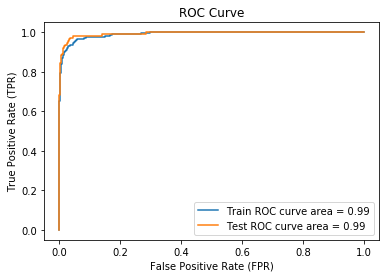

In [119]:
# roc curve for best estimator
plot_roc_curve(rs_model, X_train, X_test, y_train, y_test)

It looks pretty good. However, this result for our validation dataset. So, prediction in the final test set the important one.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [60]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [65]:
mailout_test.shape

(42833, 366)

In [66]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


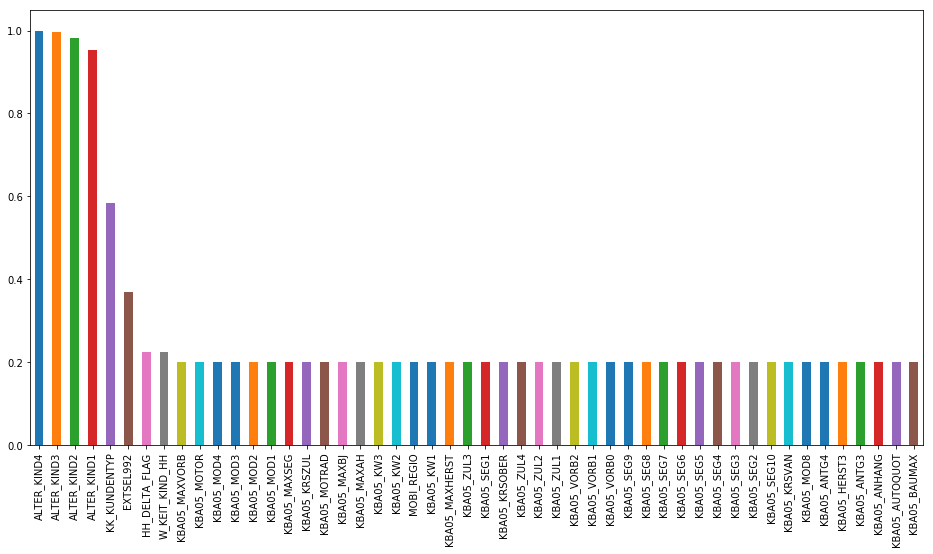

In [63]:
# null values in test dataset
mailout_test.isnull().mean().sort_values(ascending=False)[:50].plot(kind="bar", figsize=[16,8])

### 3.1. Preprocess of final test dataset

***This data prepocess function is for only final test dataset. 
We need to keep all rows for final test dataset. So, we don't drop any row.***

In [64]:
def data_preprocessing_2 (df):
    """
    ***This data prepocess function is for only final test dataset. 
    We need to keep all rows for final test dataset. So, we don't drop any row.
    
    Perform cleaning of demographics dataset by dropping missing columns only, reencoding, 
    completing missing values, and dropping correlated features
    
    Input: 
    df: Demographic dataset (DataFrame)
    df_name: Name of dataframe (str)
    
    Output:
    df_clean: Cleaned dataset (DataFrame)
    """
    # Get copy of df
    df_clean=df.copy()
    
      
    # Drop columns which involve too many missing values
    df_clean.drop(columns= ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP'], 
                  inplace=True)
    
    # Remove the columns which involve too many features
    df_clean.drop(columns=["CAMEO_DEU_2015", "CAMEO_INTL_2015", "D19_LETZTER_KAUF_BRANCHE"], inplace=True)
    
    # Change dtype of EINGEFUEGT_AM column from object to datetime and extract only year
    df_clean["EINGEFUEGT_AM"]=pd.to_datetime(df_clean["EINGEFUEGT_AM"])
    df_clean["EINGEFUEGT_AM"]=pd.DatetimeIndex(df_clean["EINGEFUEGT_AM"]).year
    
    # Convert categorical column to encoded
    df_clean["CAMEO_DEUG_2015"]=pd.factorize(df_clean["CAMEO_DEUG_2015"])[0]
    
    # Convert categorical column to encoded
    df_clean=pd.get_dummies(df_clean, drop_first=True)
        
    # Impute missing values with mode value
    imputer = SimpleImputer(strategy='most_frequent')
    df_clean=pd.DataFrame(imputer.fit_transform(df_clean), columns = df_clean.columns)
    
    # Identify and remove 45 correlated features
    
    df_clean.drop(columns=['ANZ_STATISTISCHE_HAUSHALTE', 'CJT_TYP_2', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
    'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12',
    'D19_KONSUMTYP_MAX', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM',
    'D19_VERSAND_ONLINE_QUOTE_12', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3',
    'KBA05_SEG2', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG9', 'KBA05_ZUL4', 'KBA13_HALTER_40', 'KBA13_HALTER_55',
    'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'KBA13_KMH_250', 'KBA13_SITZE_5', 'KBA13_VW', 'LP_FAMILIE_GROB',
    'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB', 'MIN_GEBAEUDEJAHR', 'ORTSGR_KLS9', 'PLZ8_ANTG1',
    'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'VK_DISTANZ', 'VK_ZG11', 'ANREDE_KZ'], inplace=True)
    

    # Standardization of dataset
    lnr=df_clean['LNR']
    scaler = StandardScaler()
    df_clean=pd.DataFrame(scaler.fit_transform(df_clean), columns = df_clean.columns)
    df_clean['LNR']=lnr
    
    # set index LNR column
    df_clean.set_index("LNR", inplace=True)

    return df_clean

In [151]:
mailout_test_clean=data_preprocessing_2(mailout_test)

In [152]:
mailout_test_clean.shape

(42833, 311)

In [153]:
mailout_test_clean.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,
1754.0,1.033789,-0.271646,-0.236176,-0.920349,-0.273330,-0.120872,-0.206929,0.108587,-0.088595,-0.211076,...,-0.052842,0.033727,1.627638,0.396115,0.659184,0.244893,-0.468790,0.178441,0.728696,0.774505
1770.0,-1.086712,-0.271646,-1.274215,-2.426369,1.047062,-0.120872,-0.206929,-0.660824,-0.088595,0.774537,...,-0.052842,0.033727,-1.245023,0.396115,0.659184,0.244893,0.579374,0.178441,0.728696,0.774505
1465.0,1.033789,4.719141,1.098445,0.334667,-0.273330,-0.120872,-0.206929,1.647408,-0.088595,0.774537,...,-0.052842,0.033727,0.670084,1.668202,-1.591635,0.244893,0.055292,0.178441,0.728696,0.774505
1470.0,-1.086712,3.471445,-1.274215,-2.426369,-0.346685,-0.120872,-0.206929,-1.430235,-0.088595,0.774537,...,0.909884,0.033727,-0.287470,0.714136,0.659184,0.244893,-0.992871,0.178441,0.728696,-1.291147
1478.0,0.326956,-0.271646,1.839902,0.836674,-0.346685,-0.120872,-0.206929,1.647408,-0.088595,-0.211076,...,-0.052842,0.033727,-1.245023,-0.557951,-1.028930,0.244893,1.627537,1.070811,0.728696,0.774505


In [178]:
# prediction by using previous model
y_test_pred=rs_model.predict(mailout_test_clean)

In [179]:
y_test_pred

array([0.5195162 , 0.49985275, 0.47559863, ..., 0.48343855, 0.5195162 ,
       0.52039075], dtype=float32)

In [180]:
y_test_pred.shape

(42833,)

In [181]:
# create dataframe by using LNR column and predictions
df_kaggle=pd.DataFrame({"RESPONSE": y_test_pred},index= mailout_test_clean.index.astype(int))

In [182]:
df_kaggle.shape

(42833, 1)

In [183]:
df_kaggle.head()

,RESPONSE
LNR,
1754,0.519516
1770,0.499853
1465,0.475599
1470,0.475599
1478,0.475599


In [184]:
df_kaggle.to_csv('kaggle_submission.csv')